<a href="https://colab.research.google.com/github/NRiccieri/HIAAC_Project_Group3/blob/main/FL_proposta_algoritmo_compressao_6_compress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FL Compression Algorithm**

**To do:**

- repeat the experiment with varying data heterogeneity (3 levels at least)
- repeat experiments with P-O-C selection algorithm only
- repeat experiments with P-O-C + CountSketch
- repeat experiments with CountSketch

**Metrics:**

- speed of convergence (number of rounds required to get target accuracy score)
- volume of communication per round
- number of clients-central server communications


### **Experiment parameters**

In [2]:
#FL environment parameters

num_clients = 35   #total number of devices in the FL environment
percentage_clients_considered = .4    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = int(num_clients*percentage_clients_considered)
num_clients_selected = int(percentage_clients_selected*num_clients_considered)


#training parameters
num_iterations_per_round = 15 #number of iterations executed by clients at each round of the algorithm

max_num_rounds = 300

validation_size = 0.15

epsilon = 0.0 #difference between the trained FL global model accuracy score and the centralised model accuracy score

accuracy_score_target = 0.9


RO = 0.8 # Momentum rate
ETA = 1.0  # Learning rate

# CSVec parameters
CSVEC_C = 5000
CSVEC_COMPRESSION = 0.1
CSVEC_K = 200

Note: In the centralized training, given the architecture used (3 hidden layers with 256 units), we reach an accuracy score of about 98.5% in 120 epochs on the training set. **The accuracy score on the testing data is around 91%.** The training time is 2 minutes 22 seconds.

**In the Federated Learning environment, the goal is for the global model located in the central server to be as close as possible to an accuracy score of 91% on the test data.**


## **Importing the dataset from Kaggle**

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
#create gdrive folder inside content
from google.colab import drive
drive.mount('/content/gdrive')

#importing dataset to google colab from gdrive
!cp /content/gdrive/MyDrive/kaggle_datasets/archive.zip  /content/archive.zip 

#unzipping 
!unzip archive.zip 

Mounted at /content/gdrive
Archive:  archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [5]:
#train dataset that will be split between all clients
df_train = pd.read_csv('train.csv')

x_train = pd.DataFrame(df_train.drop(['Activity','subject'],axis=1))
y_train = df_train.Activity.values.astype(object)

#test dataset that will be located in central server
df_test = pd.read_csv('test.csv')

central_server_data_x = pd.DataFrame(df_test.drop(['Activity','subject'],axis=1))
central_server_data_y_true = df_test.Activity.values.astype(object)

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

encoder=preprocessing.LabelEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train)
print(encoder.classes_)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

#scaling central server dataset
central_server_data_x = scaler.transform(central_server_data_x)
central_server_data_y_true = encoder.transform(central_server_data_y_true)

#creating the datasets
#x_test/y_test could be used by server to check gloabl model accuracy
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=100)

['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


## **Creating datasets for each client**

In [7]:
#returns an object with clientID as key, and its dataset
def returnDatasetPerClientObject(x, y):
  datasetObject = []

  n = x.shape[0]
  m = int(n/num_clients)

  i = 0
  while i < num_clients:
    client_i_x = x[ m * i :  m * (i + 1) ]
    client_i_y = y[ m * i :  m * (i + 1) ]
    datasetObject.append({"x": client_i_x, "y": client_i_y})
    i +=1

  return datasetObject


#returns the dataset x/y of a client
def returnDatasetForClient(clientid, datasetObject):
  return {"x" : datasetObject[clientid]["x"] , "y" : datasetObject[clientid]["y"]}


#returns dataset per client per subject in the dataframe
def returnDatasetPerClientObjectPerPerson(trainingdataframe):
  datasetObject = []

  trainx = pd.DataFrame(trainingdataframe.drop(['Activity','subject'],axis=1))
  trainy = trainingdataframe.Activity.values.astype(object)

  #test dataset that will be located in central server
  #testx = pd.DataFrame(testdataframe.drop(['Activity','subject'],axis=1))
  #testy = testdataframe.Activity.values.astype(object)  

  encoder=preprocessing.LabelEncoder()
  encoder.fit(trainy)
  scaler = StandardScaler()
  scaler.fit(trainx)

  #scaling test dataset
  #testx = scaler.transform(testx)
  #testy = encoder.transform(testy)

  subjectlist = trainingdataframe['subject'].unique()

  for subject in subjectlist:
    resultdataframe = trainingdataframe.loc[trainingdataframe['subject'] == subject] 

    subjectdatax = pd.DataFrame(resultdataframe.drop(['Activity','subject'],axis=1))
    subjectdatay = resultdataframe.Activity.values.astype(object)

    subjectdatax = scaler.transform(subjectdatax)
    subjectdatay = encoder.transform(subjectdatay)

    datasetObject.append({"x": subjectdatax, "y": subjectdatay})

  return datasetObject

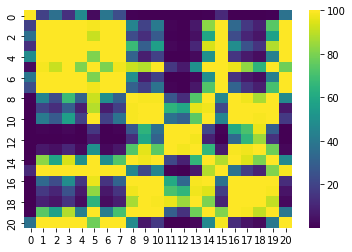

In [ ]:
import numpy as np
from scipy.stats import ks_2samp
import seaborn as sns
import pandas as pd
import numpy as np

clients_dataset = returnDatasetPerClientObjectPerPerson(df_train)

clientIDs_list = [0 for x in range(21)]
client_y_list = []

for clientid in clientIDs_list:
  client_data = returnDatasetForClient(clientid, clients_dataset)
  client_y_list.append(client_data["y"])

ks_matrix = [[0 for x in range(21)] for y in range(21)] 

i = 0
while i < 21:
  client_data = returnDatasetForClient(i, clients_dataset)
  i_data_y = client_data["y"]
  j = i + 1
  ks_matrix[i][i] = 100
  while j < 21:
    client_data = returnDatasetForClient(j, clients_dataset)
    j_data_y = client_data["y"]
    p_value_ij = ks_2samp(i_data_y, j_data_y)
    ks_matrix[i][j] = p_value_ij[1] * 100
    ks_matrix[j][i] = p_value_ij[1] * 100
    j+=1
  i +=1


# Create a dataset
df = pd.DataFrame(ks_matrix)

# Default heatmap
p1 = sns.heatmap(df, cmap='viridis')

## **Dataset distribution analysis**

In [ ]:
import numpy as np
from scipy.stats import ks_2samp

clients_dataset = returnDatasetPerClientObject(x_train, y_train)

clientIDs_list = [0 for x in range(35)]
client_y_list = []

for clientid in clientIDs_list:
  client_data = returnDatasetForClient(clientid, clients_dataset)
  client_y_list.append(client_data["y"])

ks_matrix = [[0 for x in range(35)] for y in range(35)] 

i = 0
while i < 34:
  client_data = returnDatasetForClient(i, clients_dataset)
  i_data_y = client_data["y"]
  j = i + 1
  ks_matrix[i][i] = 100
  while j <= 34:
    client_data = returnDatasetForClient(j, clients_dataset)
    j_data_y = client_data["y"]
    p_value_ij = ks_2samp(i_data_y, j_data_y)
    print("i", i, " - ", j)
    print(p_value_ij)
    ks_matrix[i][j] = p_value_ij[1] * 100
    ks_matrix[j][i] = p_value_ij[1] * 100
    j+=1
  i +=1

i 0  -  1
Ks_2sampResult(statistic=0.1, pvalue=0.24484766664021126)
i 0  -  2
Ks_2sampResult(statistic=0.09047619047619047, pvalue=0.35708139775157355)
i 0  -  3
Ks_2sampResult(statistic=0.20476190476190476, pvalue=0.0002879233982750585)
i 0  -  4
Ks_2sampResult(statistic=0.1, pvalue=0.24484766664021126)
i 0  -  5
Ks_2sampResult(statistic=0.1380952380952381, pvalue=0.03634005135145496)
i 0  -  6
Ks_2sampResult(statistic=0.20476190476190476, pvalue=0.0002879233982750585)
i 0  -  7
Ks_2sampResult(statistic=0.10952380952380952, pvalue=0.16114843967701345)
i 0  -  8
Ks_2sampResult(statistic=0.07142857142857142, pvalue=0.6588790408805515)
i 0  -  9
Ks_2sampResult(statistic=0.06666666666666667, pvalue=0.7403980129715481)
i 0  -  10
Ks_2sampResult(statistic=0.14285714285714285, pvalue=0.027406536979545183)
i 0  -  11
Ks_2sampResult(statistic=0.13333333333333333, pvalue=0.04772095526130206)
i 0  -  12
Ks_2sampResult(statistic=0.1, pvalue=0.24484766664021126)
i 0  -  13
Ks_2sampResult(statistic

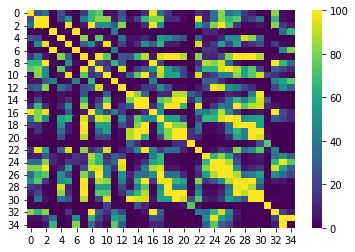

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

# Create a dataset
df = pd.DataFrame(ks_matrix)

# Default heatmap
p1 = sns.heatmap(df, cmap='viridis')

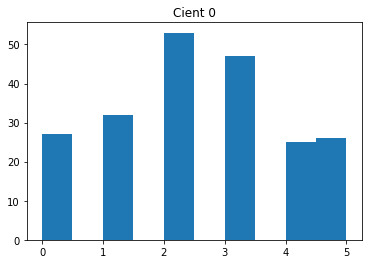

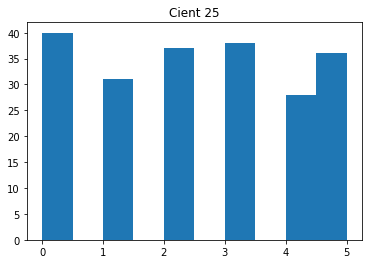

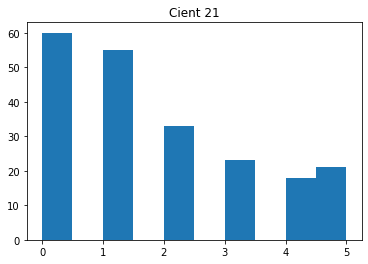

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(client_y_list[0])
plt.title("Cient 0")
plt.show()

plt.hist(client_y_list[25])
plt.title("Cient 25")
plt.show()

plt.hist(client_y_list[21])
plt.title("Cient 21")
plt.show()

## **Machine learning model implementation**

**In TensorFlow**

**Functions in central server side**

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt


def returnInitialGlobalModel():

  model = Sequential([
      
      # input layer
      Flatten(input_shape=(561,), name="inputlayer"),
      
      # dense layer 1
      Dense(256, activation='sigmoid', name="firstlayer"),  
      
      # dense layer 2
      Dense(256, activation='sigmoid', name="secondlayer"), 

      # dense layer 3
      Dense(256, activation='sigmoid', name="thirdlayer"), 
      
      # output layer
      Dense(6, activation='sigmoid', name="outputlayer"),  
  ])

  model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model


#returns a copy of the global model to client
def returnCopyGlobalModelToClient(globalmodel):

  clientmodel = returnInitialGlobalModel()
  clientmodel.set_weights(globalmodel.get_weights()) 

  return clientmodel


#function that returns the accuracy score of the global model on the client's data
def evaluateGlobalModel(globalmodel, x, y):
  
  results = globalmodel.evaluate(x, y, verbose=0)

  return results




############previous code

#function that uncompresses the gradient from the clients
def uncompressClientsGradientPast(clientscompressedgradientobject):

  clientsUncompressedradientobject = clientscompressedgradientobject
  
  return clientsUncompressedradientobject

#add the client gradient to the global model
def addGradientNoCompression(modelNotTrained, gradient):
  newWeight = []
  i = 0
  notTrainedWeight = modelNotTrained.get_weights()
  for weight in modelNotTrained.get_weights():
    newWeight.append( weight - (gradient[i] / num_clients_selected) )
    i += 1
  modelNotTrained.set_weights(newWeight)

############end previous code




#function that uncompresses the gradient from the clients
def uncompressClientsGradient(clientscompressedgradientobject, s_u, s_e):
    global csvec

    if s_u is None:
        s_u = np.zeros(csvec.table.shape)
        s_e = np.zeros(csvec.table.shape)

    csvec.zero()

    for client in clientscompressedgradientobject:
        csvec.accumulateTable(client['clientgradient'])

    s_u = RO * s_u + csvec.table / len(clientscompressedgradientobject)

    csvec.table = ETA * s_u + s_e
    delta = csvec.unSketch(k=CSVEC_K)

    csvec.zero()
    csvec.accumulateVec(delta)
    s_e = ETA * s_u + s_e - csvec.table

    return s_u, s_e, delta

#add the client gradient to the global model
def addGradient(modelNotTrained, delta):
    dimension_counter = 0
    new_weight = []
    for weight in modelNotTrained.get_weights():
        shape = weight.shape
        delta_slice = delta[dimension_counter: dimension_counter + np.prod(shape)].reshape(shape)
        new_weight.append(weight - delta_slice)
        dimension_counter += np.prod(shape)

    modelNotTrained.set_weights(new_weight)





# #update the central server model with the gradient from clients
# def updateGlobalModelWeights(globalmodel, clientsgradientobject):

#   for clientgradient in clientsgradientobject:
#     i = 0
#     for layer in globalmodel.layers:
#       if i >= 1:
#         j = 0
#         for weight in layer.weights:
#           current_weights = layer.weights[j]
#           globalmodel.layers[i].weights[j] = current_weights - clientgradient["clientgradient"].layers[i].weights[j] / num_clients_selected
#           j += 1
#       i +=1

**Functions in clients side**

In [9]:
#returns the compressed gradient to be sent to central server
def compressGradientNoCompression(clientgradient):
  
  compressedclientgradient = clientgradient
  return compressedclientgradient

#Given the weights after training and initial weights, returns the gradient from entire training
def computeClientGradientNoCompression(modelNotTrained, modelTrained):
  gradient = []
  notTrainedWeight = modelNotTrained.get_weights()
  i = 0
  for weight in modelTrained.get_weights():
    gradient.append( notTrainedWeight[i] - weight )
    i += 1
  return gradient

In [10]:
#returns the compressed gradient to be sent to central server
def compressGradient(clientgradient):
    global csvec

    gradient_vector = np.concatenate([g.reshape((-1,)) for g in clientgradient])
    gradients_size = gradient_vector.shape[0]

    if csvec is None:
        csvec_rows = max(1, round(CSVEC_COMPRESSION*gradients_size/CSVEC_C))
        csvec = CSVec(gradients_size, CSVEC_C, csvec_rows)
        print(f'Creating CSVEC Table\n   Columns: {CSVEC_C}\n   Rows: {csvec_rows}\n   '
              f'Compression: {CSVEC_C*csvec_rows/gradients_size}')
    csvec.zero()
    csvec.accumulateVec(gradient_vector)

    compressedclientgradient = csvec.table
    return compressedclientgradient

#Given the weights after training and initial weights, returns the gradient from entire training
def computeClientGradient(modelNotTrained, modelTrained):
  gradient = []
  notTrainedWeight = modelNotTrained.get_weights()
  i = 0
  for weight in modelTrained.get_weights():
    gradient.append( notTrainedWeight[i] - weight )
    i += 1
  return gradient

## **CountSketch Implementation**

In [11]:
import copy
import math

LARGEPRIME = 2**61-1

cache = {}

class CSVec(object):
    """ Count Sketch of a vector

    Treating a vector as a stream of tokens with associated weights,
    this class computes the count sketch of an input vector, and
    supports operations on the resulting sketch.

    public methods: zero, unSketch, l2estimate, __add__, __iadd__
    """

    def __init__(self, d, c, r, doInitialize=True,
                 numBlocks=1):
        """ Constductor for CSVec

        Args:
            d: the cardinality of the skteched vector
            c: the number of columns (buckets) in the sketch
            r: the number of rows in the sketch
            doInitialize: if False, you are responsible for setting
                self.table, self.signs, self.buckets, self.blockSigns,
                and self.blockOffsets
            numBlocks: mechanism to reduce memory consumption. A value
                of 1 leads to a normal sketch. Higher values reduce
                peak memory consumption proportionally but decrease
                randomness of the hashes
        Note:
            Since sketching a vector always requires the hash functions
            to be evaluated for all of 0..d-1, we precompute the
            hash values in the constructor. However, this takes d*r
            memory, which is sometimes too big. We therefore only
            compute hashes of 0..(d/numBlocks - 1), and we let the
            hash of all other tokens be the hash of that token modulo
            d/numBlocks. In order to recover some of the lost randomness,
            we add a random number to each "block" (self.blockOffsets)
            and multiply each block by a random sign (self.blockSigns)
        """
        
        # save random quantities in a module-level variable so we can
        # reuse them if someone else makes a sketch with the same d, c, r
        global cache

        self.r = r  # num of rows
        self.c = c  # num of columns
        # need int() here b/c annoying np returning np.int64...
        self.d = int(d)  # vector dimensionality

        # reduce memory consumption of signs & buckets by constraining
        # them to be repetitions of a single block
        self.numBlocks = numBlocks

        # this flag indicates that the caller plans to set up
        # self.signs, self.buckets, self.blockSigns, and self.blockOffsets
        # itself (e.g. self.deepcopy does this)
        if not doInitialize:
            return

        # initialize the sketch to all zeros
        self.table = np.zeros((r, c))

        # if we already have these, don't do the same computation
        # again (wasting memory storing the same data several times)
        cacheKey = (d, c, r, numBlocks)
        if cacheKey in cache:
            self.signs = cache[cacheKey]["signs"]
            self.buckets = cache[cacheKey]["buckets"]
            if self.numBlocks > 1:
                self.blockSigns = cache[cacheKey]["blockSigns"]
                self.blockOffsets = cache[cacheKey]["blockOffsets"]
            return
        
        # initialize hashing functions for each row:
        # 2 random numbers for bucket hashes + 4 random numbers for
        # sign hashes
        # maintain existing random state so we don't mess with
        # the main module trying to set the random seed but still
        # get reproducible hashes for the same value of r

        # do all these computations on the CPU, since pytorch
        # is incapable of in-place mod, and without that, this
        # computation uses up too much GPU RAM
        rand_state = np.random.get_state()
        np.random.seed(42)
        hashes = np.random.randint(0, LARGEPRIME, (r, 6))

        # compute random blockOffsets and blockSigns
        if self.numBlocks > 1:
            nTokens = self.d // numBlocks
            if self.d % numBlocks != 0:
                # so that we only need numBlocks repetitions
                nTokens += 1
            self.blockSigns = np.random.randint(0, 2, size=(self.numBlocks,)) * 2 - 1
            self.blockOffsets = np.random.randint(0, self.c,
                                                  size=(self.numBlocks,))
        else:
            assert (numBlocks == 1)
            nTokens = self.d

        np.random.set_state(rand_state)

        # tokens are the indices of the vector entries
        tokens = np.arange(nTokens)
        tokens = tokens.reshape((1, nTokens))

        # computing sign hashes (4 wise independence)
        h1 = hashes[:, 2:3]
        h2 = hashes[:, 3:4]
        h3 = hashes[:, 4:5]
        h4 = hashes[:, 5:6]
        self.signs = (((h1 * tokens + h2) * tokens + h3) * tokens + h4)
        self.signs = ((self.signs % LARGEPRIME % 2) * 2 - 1)

        # computing bucket hashes (2-wise independence)
        h1 = hashes[:, 0:1]
        h2 = hashes[:, 1:2]
        self.buckets = ((h1 * tokens) + h2) % LARGEPRIME % self.c

        cache[cacheKey] = {"signs": self.signs,
                           "buckets": self.buckets}
        if numBlocks > 1:
            cache[cacheKey].update({"blockSigns": self.blockSigns,
                                    "blockOffsets": self.blockOffsets})

    def zero(self):
        """ Set all the entries of the sketch to zero """
        self.table = np.zeros(self.table.shape)

    def half_(self):
        self.table = self.table.astype(np.int16)

    def float_(self):
        self.table = self.table.astype(np.float_)

    def __deepcopy__(self, memodict={}):
        # don't initialize new CSVec, since that will calculate bc,
        # which is slow, even though we can just copy it over
        # directly without recomputing it
        newCSVec = CSVec(d=self.d, c=self.c, r=self.r,
                         doInitialize=False,
                         numBlocks=self.numBlocks)
        newCSVec.table = copy.deepcopy(self.table)
        global cache
        cachedVals = cache[(self.d, self.c, self.r, self.numBlocks)]
        newCSVec.signs = cachedVals["signs"]
        newCSVec.buckets = cachedVals["buckets"]
        if self.numBlocks > 1:
            newCSVec.blockSigns = cachedVals["blockSigns"]
            newCSVec.blockOffsets = cachedVals["blockOffsets"]
        return newCSVec

    def __imul__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            self.table = self.table.mul_(other)
        else:
            raise ValueError(f"Can't multiply a CSVec by {other}")
        return self

    def __truediv__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            self.table = self.table.div_(other)
        else:
            raise ValueError(f"Can't divide a CSVec by {other}")
        return self


    def __add__(self, other):
        """ Returns the sum of self with other

        Args:
            other: a CSVec with identical values of d, c, and r
        """
        # a bit roundabout in order to avoid initializing a new CSVec
        returnCSVec = copy.deepcopy(self)
        returnCSVec += other
        return returnCSVec

    def __iadd__(self, other):
        """ Accumulates another sketch

        Args:
            other: a CSVec with identical values of d, c, r, numBlocks
        """
        if isinstance(other, CSVec):
            # merges csh sketch into self
            assert (self.d == other.d)
            assert (self.c == other.c)
            assert (self.r == other.r)
            assert (self.numBlocks == other.numBlocks)
            self.table += other.table
        else:
            raise ValueError("Can't add this to a CSVec: {}".format(other))
        return self

    def accumulateTable(self, table):
        """ Adds a CSVec.table to self

        Args:
            table: the table to be added

        """
        if table.shape != self.table.shape:
            msg = "Passed in table has size {}, expecting {}"
            raise ValueError(msg.format(table.size(), self.table.size()))

        self.table += table

    def accumulateVec(self, vec):
        """ Sketches a vector and adds the result to self

        Args:
            vec: the vector to be sketched
        """
        size = vec.shape if type(vec) == np.ndarray else vec.size()
        assert (len(size) == 1 and size[0] == self.d)

        # the vector is sketched to each row independently
        for r in range(self.r):
            buckets = self.buckets[r, :]
            signs = self.signs[r, :]
            # the main computation here is the bincount below, but
            # there's lots of index accounitng leading up to it due
            # to numBlocks being potentially > 1
            for blockId in range(self.numBlocks):
                start = blockId * buckets.shape[0]
                end = (blockId + 1) * buckets.shape[0]
                end = min(end, self.d)
                offsetBuckets = buckets[:end - start].copy()
                offsetSigns = signs[:end - start].copy()
                if self.numBlocks > 1:
                    offsetBuckets += self.blockOffsets[blockId]
                    offsetBuckets %= self.c
                    offsetSigns *= self.blockSigns[blockId]
                # bincount computes the sum of all values in the vector
                # that correspond to each bucket
                self.table[r, :] += np.bincount(
                    offsetBuckets,
                    weights=offsetSigns * np.array(vec)[start:end],
                    minlength=self.c
                )
    def _findHHK(self, k):
        assert (k is not None)
        vals = self._findAllValues()

        # sort is faster than torch.topk...
        # HHs = torch.sort(vals**2)[1][-k:]

        # topk on cuda returns what looks like uninitialized memory if
        # vals has nan values in it
        # saving to a zero-initialized output array instead of using the
        # output of topk appears to solve this problem
        # outVals = np.zeros(k)
        # HHs = np.zeros(k)
        # torch.topk(vals**2, k, sorted=False, out=(outVals, HHs))
        HHs = np.argpartition(vals ** 2, -k)[-k:]
        return HHs, vals[HHs]

    def _findHHThr(self, thr):
        assert (thr is not None)
        vals = self._findAllValues()
        HHs = np.abs(vals) >= thr
        return HHs, vals[HHs]

    def _findValues(self, coords):
        # estimating frequency of input coordinates
        assert (self.numBlocks == 1)
        d = coords.size()[0]
        vals = np.zeros((self.r, self.d))
        for r in range(self.r):
            vals[r] = (self.table[r, self.buckets[r, coords]]
                       * self.signs[r, coords])
        return np.median(vals, axis=0)


    def _findAllValues(self):
        if self.numBlocks == 1:
            vals = np.zeros((self.r, self.d))
            for r in range(self.r):
                vals[r] = (self.table[r, self.buckets[r, :]]
                           * self.signs[r, :])
            return np.median(vals, axis=0)
        else:
            medians = np.zeros(self.d)
            for blockId in range(self.numBlocks):
                start = blockId * self.buckets.size()[1]
                end = (blockId + 1) * self.buckets.size()[1]
                end = min(end, self.d)
                vals = np.zeros((self.r, end - start))
                for r in range(self.r):
                    buckets = self.buckets[r, :end - start]
                    signs = self.signs[r, :end - start]
                    offsetBuckets = buckets + self.blockOffsets[blockId]
                    offsetBuckets %= self.c
                    offsetSigns = signs * self.blockSigns[blockId]
                    vals[r] = (self.table[r, offsetBuckets]
                               * offsetSigns)
                medians[start:end] = np.median(vals, axis=0)
            return medians

    def _findHHs(self, k=None, thr=None):
        assert ((k is None) != (thr is None))
        if k is not None:
            return self._findHHK(k)
        else:
            return self._findHHThr(thr)

    def unSketch(self, k=None, epsilon=None):
        """ Performs heavy-hitter recovery on the sketch

        Args:
            k: if not None, the number of heavy hitters to recover
            epsilon: if not None, the approximation error in the recovery.
                The returned heavy hitters are estimated to be greater
                than epsilon * self.l2estimate()

        Returns:
            A vector containing the heavy hitters, with zero everywhere
            else

        Note:
            exactly one of k and epsilon must be non-None
        """

        # either epsilon or k might be specified
        # (but not both). Act accordingly
        if epsilon is None:
            thr = None
        else:
            thr = epsilon * self.l2estimate()

        hhs = self._findHHs(k=k, thr=thr)

        if k is not None:
            assert (len(hhs[1]) == k)
        if epsilon is not None:
            assert ((hhs[1] < thr).sum() == 0)

        # the unsketched vector is 0 everywhere except for HH
        # coordinates, which are set to the HH values
        unSketched = np.zeros(self.d)
        unSketched[hhs[0]] = hhs[1]
        return unSketched

    def l2estimate(self):
        """ Return an estimate of the L2 norm of the sketch """
        # l2 norm esimation from the sketch
        return np.sqrt(np.median(np.sum(self.table ** 2, axis=1)))

    @classmethod
    def median(cls, csvecs):
        # make sure all CSVecs match
        d = csvecs[0].d
        c = csvecs[0].c
        r = csvecs[0].r
        numBlocks = csvecs[0].numBlocks
        for csvec in csvecs:
            assert (csvec.d == d)
            assert (csvec.c == c)
            assert (csvec.r == r)
            assert (csvec.numBlocks == numBlocks)

        tables = [csvec.table for csvec in csvecs]
        med = np.median(np.stack(tables), axis=0)
        returnCSVec = copy.deepcopy(csvecs[0])
        returnCSVec.table = med
        return returnCSVec


csvec = None



## **Central server logic implementation**

In [12]:
import random


#Generate a random list of clients considered of length num_clients_considered
def returnRandomSelectedClientsIDsList():
  return random.sample(range(0, num_clients), num_clients_considered)


#function that returns the evaluation of the global model on the selected clients
def returnWorstLossesAmongChosenClients(classifierModel, chosenClients, datasetObject):
  
  clients_accuracy_list = [] #modelEvaluationObject()
  j = 0 
  
  #evaluate the classifier on each random client's data
  while j < len(chosenClients):
    
    client_id = chosenClients[j]
    client_dataset = returnDatasetForClient(client_id, datasetObject)
    client_evaluation_score = evaluateGlobalModel(classifierModel, client_dataset["x"], client_dataset["y"])
    
    clients_accuracy_list.append({"clientID": client_id, "accuracy": client_evaluation_score[1]})

    j+= 1

  #order the losses from worst to best
  clients_accuracy_list.sort(key=lambda x: x["accuracy"], reverse=False)

  return clients_accuracy_list



#main code running on server side
def runTrainingNoCompression(classifierModel, accuracyScoreTarget, clientsDatasetObject):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []
  per_round_global_model_loss = []
  convergence_reached_at_round = 0
  
  randomly_considered_clients_per_round_list = [] #saving the clients considered on each round to repeat the experiment 

  while i < max_num_rounds:

      #print("Round ", i + 1, " / Max rounds ", max_num_rounds)
      
      #select random clients
      random_clients = returnRandomSelectedClientsIDsList()

      #return the list of clients with loss value from worst to best
      pretraining_loss_values_obj = returnWorstLossesAmongChosenClients(classifierModel, random_clients, clientsDatasetObject)

      #save the clients randomly selected to repeat the experiment with lesser clients selected
      randomly_considered_clients_per_round_list.append(pretraining_loss_values_obj)

      #print("Model evaluation on clients : ", pretraining_loss_values_obj)
      #print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradientNoCompression(classifierModel, client_model)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      #selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      #updating the global model weights
      for client_gradient in selected_clients_grad_list:
        addGradientNoCompression(classifierModel, client_gradient["clientgradient"])

      
      #evaluating the global model on data contained in central server
      globalModelEvaluation = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      globalAccuracy = globalModelEvaluation[1]
      per_round_global_model_accuracy.append(globalAccuracy)
      per_round_global_model_loss.append(globalModelEvaluation[0])

      #print("Current global model accuracy score = ", globalAccuracy)
      #print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon and convergence_reached_at_round == 0:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        convergence_reached_at_round = i

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)
  print("Number of rounds until convergence : ", convergence_reached_at_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per round')
  plt.show()

  plt.plot(per_round_global_model_loss)
  plt.ylabel('Loss per round')
  plt.show()
  
  return [classifierModel, per_round_global_model_accuracy, per_round_global_model_loss, convergence_reached_at_round, randomly_considered_clients_per_round_list]







#main code running on server side
def runTrainingWithCompression(classifierModel, accuracyScoreTarget, clientsDatasetObject):

  global csvec
  csvec = None


  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []
  per_round_global_model_loss = []
  convergence_reached_at_round = 0
  
  randomly_considered_clients_per_round_list = [] #saving the clients considered on each round to repeat the experiment 


  s_u = s_e = None

  
  while i < max_num_rounds:

      #print("Round ", i + 1, " / Max rounds ", max_num_rounds)
      
      #select random clients
      random_clients = returnRandomSelectedClientsIDsList()

      #return the list of clients with loss value from worst to best
      pretraining_loss_values_obj = returnWorstLossesAmongChosenClients(classifierModel, random_clients, clientsDatasetObject)

      #save the clients randomly selected to repeat the experiment with lesser clients selected
      randomly_considered_clients_per_round_list.append(pretraining_loss_values_obj)

      #print("Model evaluation on clients : ", pretraining_loss_values_obj)
      #print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      # #uncompress the gradient from clients
      # selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      # #updating the global model weights
      # for client_gradient in selected_clients_grad_list:
      #   addGradient(classifierModel, client_gradient["clientgradient"])


      #uncompress the gradient from clients
      s_u, s_e, delta = uncompressClientsGradient(selected_clients_grad_list, s_u, s_e)

      # updating the global model weights
      addGradient(classifierModel, delta)

      

      #evaluating the global model on data contained in central server
      globalModelEvaluation = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      globalAccuracy = globalModelEvaluation[1]
      per_round_global_model_accuracy.append(globalAccuracy)
      per_round_global_model_loss.append(globalModelEvaluation[0])

      #print("Current global model accuracy score = ", globalAccuracy)
      #print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon and convergence_reached_at_round == 0:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        convergence_reached_at_round = i

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)
  print("Number of rounds until convergence : ", convergence_reached_at_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per round')
  plt.show()

  plt.plot(per_round_global_model_loss)
  plt.ylabel('Loss per round')
  plt.show()
  
  return [classifierModel, per_round_global_model_accuracy, per_round_global_model_loss, convergence_reached_at_round, randomly_considered_clients_per_round_list]


In [13]:

#main code running on server side
def repeatExperiment(classifierModel, accuracyScoreTarget, clientsDatasetObject, clientsConsideredHistory):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []
  per_round_global_model_loss = []
  convergence_reached_at_round = 0
  
  while i < max_num_rounds:

      #print("Model evaluation on clients : ", pretraining_loss_values_obj)
      #print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      pretraining_loss_values_obj = clientsConsideredHistory[i]

      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradientNoCompression(classifierModel, client_model)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      #selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      #updating the global model weights
      for client_gradient in selected_clients_grad_list:
        addGradientNoCompression(classifierModel, client_gradient["clientgradient"])

      #evaluating the global model on data contained in central server
      globalModelEvaluation = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      globalAccuracy = globalModelEvaluation[1]

      per_round_global_model_accuracy.append(globalAccuracy)
      per_round_global_model_loss.append(globalModelEvaluation[0])
      #print("Current global model accuracy score = ", globalAccuracy)
      #print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon and convergence_reached_at_round == 0:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        convergence_reached_at_round = i
        #break

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)
  print("Number of rounds until convergence : ", convergence_reached_at_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per round')
  plt.show()

  plt.plot(per_round_global_model_loss)
  plt.ylabel('Loss per round')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy, per_round_global_model_loss, convergence_reached_at_round]



#main code running on server side
def repeatExperimentWithCompression(classifierModel, accuracyScoreTarget, clientsDatasetObject, clientsConsideredHistory):

  global csvec
  csvec = None

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []
  per_round_global_model_loss = []
  convergence_reached_at_round = 0
  
  s_u = s_e = None

  while i < max_num_rounds:

      #print("Model evaluation on clients : ", pretraining_loss_values_obj)
      #print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      pretraining_loss_values_obj = clientsConsideredHistory[i]

      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      s_u, s_e, delta = uncompressClientsGradient(selected_clients_grad_list, s_u, s_e)

      # updating the global model weights
      addGradient(classifierModel, delta)

      #evaluating the global model on data contained in central server
      globalModelEvaluation = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      globalAccuracy = globalModelEvaluation[1]

      per_round_global_model_accuracy.append(globalAccuracy)
      per_round_global_model_loss.append(globalModelEvaluation[0])
      #print("Current global model accuracy score = ", globalAccuracy)
      #print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon and convergence_reached_at_round == 0:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        convergence_reached_at_round = i
        #break

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)
  print("Number of rounds until convergence : ", convergence_reached_at_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per round')
  plt.show()

  plt.plot(per_round_global_model_loss)
  plt.ylabel('Loss per round')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy, per_round_global_model_loss, convergence_reached_at_round]

## **Experiments**

### **Power-Of-Choice Selection**

Among all participating clients, we select only a portion of the clients with the worst accuracy score for training the global model

**15 participating clients and 10 selected clients**

Starting
Before training global model accuracy = [2.2287657260894775, 0.15982355177402496]


Global model converged
Convergence accuracy score =  0.9029521346092224
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  10
Number of iterations per client per round :  10
Number of rounds until convergence :  150


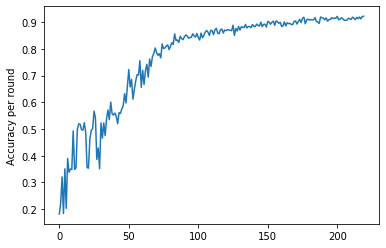

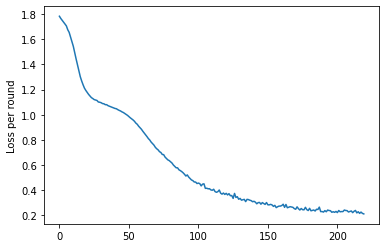

In [ ]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc, loss_history_poc, num_rounds, clients_considered_history = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

**15 participating clients and 8 selected clients for training**

Starting
Before training global model accuracy = [2.0551106929779053, 0.18221920728683472]


Global model converged
Convergence accuracy score =  0.9073634147644043
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  8
Number of iterations per client per round :  10
Number of rounds until convergence :  156


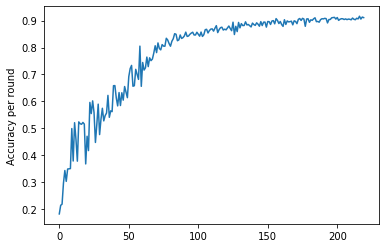

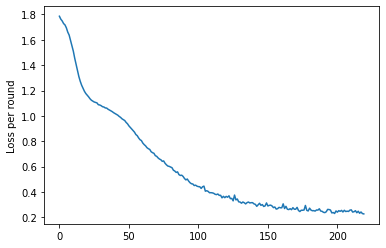

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 8 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_8, loss_history_poc_15_8, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


**15 participating clients and 6 selected clients**

Starting
Before training global model accuracy = [1.9489299058914185, 0.1425178200006485]


Global model converged
Convergence accuracy score =  0.9043094515800476
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  6
Number of iterations per client per round :  10
Number of rounds until convergence :  150


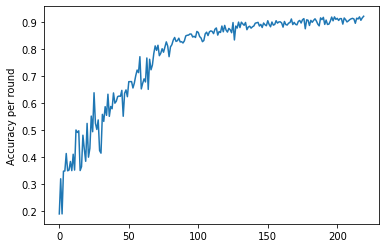

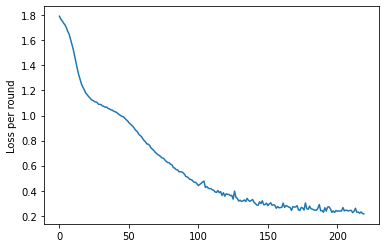

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 6 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_6, loss_history_poc_15_6, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


**15 participating and 4 selected clients**

Starting
Before training global model accuracy = [1.99135422706604, 0.1425178200006485]


Global model converged
Convergence accuracy score =  0.9107567071914673
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  4
Number of iterations per client per round :  10
Number of rounds until convergence :  142


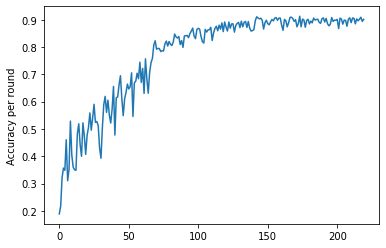

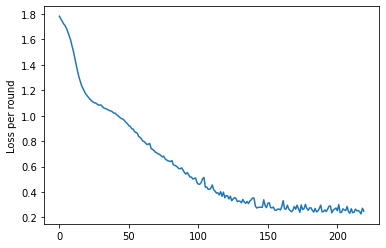

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 4 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_4, loss_history_poc_15_4, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


Starting
Before training global model accuracy = [2.006092071533203, 0.18221920728683472]


Global model converged
Convergence accuracy score =  0.9019341468811035
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  15
Number of iterations per client per round :  10
Number of rounds until convergence :  154


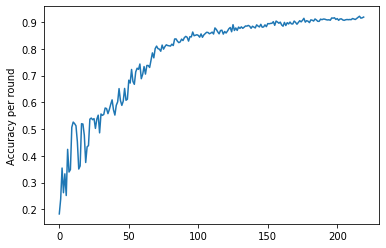

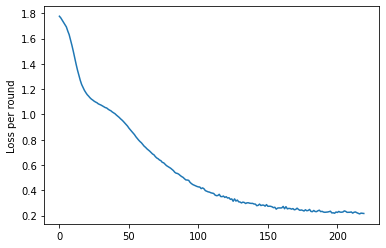

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 15 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_15, loss_history_poc_15_15, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


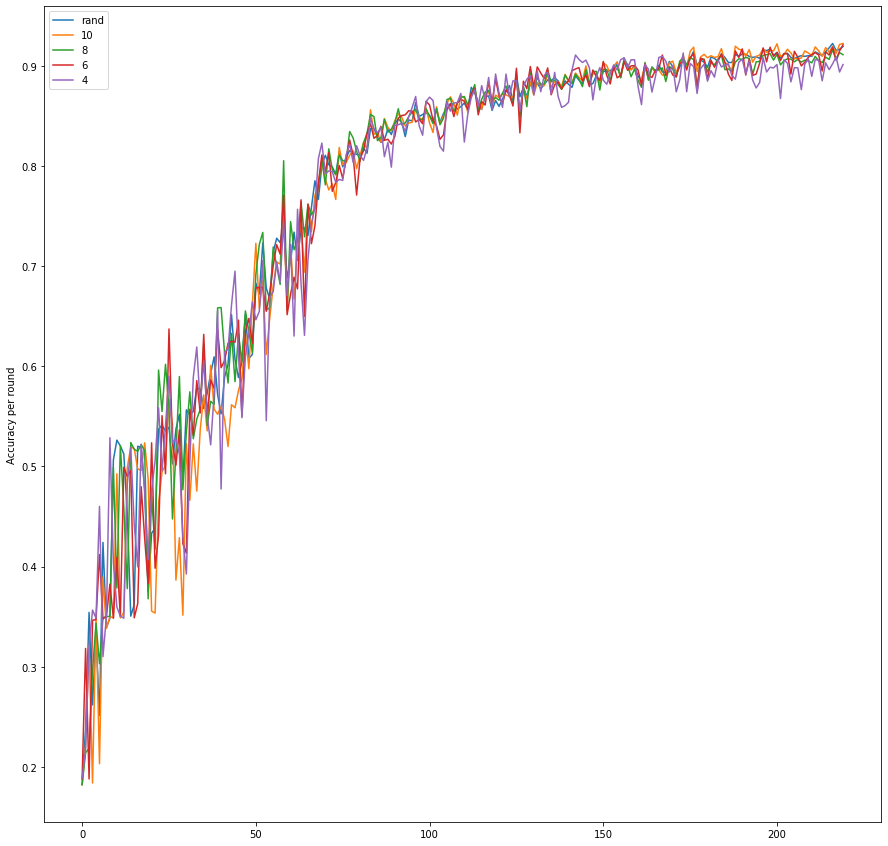

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_15_15)
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history_poc_15_8)
plt.plot(accuracy_history_poc_15_6)
plt.plot(accuracy_history_poc_15_4)
plt.ylabel('Accuracy per round')
plt.legend(["rand","10", "8", "6", "4"])

plt.show()

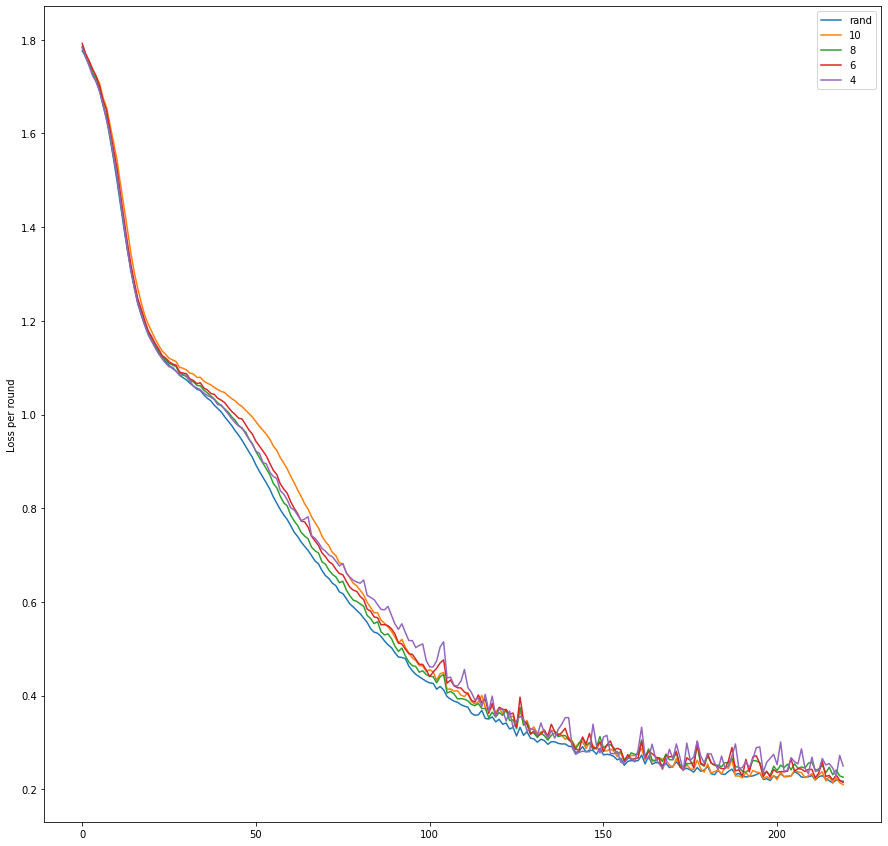

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_15_15)
plt.plot(loss_history_poc)
plt.plot(loss_history_poc_15_8)
plt.plot(loss_history_poc_15_6)
plt.plot(loss_history_poc_15_4)
plt.ylabel('Loss per round')
plt.legend(["rand","10", "8", "6", "4"])

plt.show()

In [ ]:
print(accuracy_history_poc)
print(accuracy_history_poc_15_15)
print(accuracy_history_poc_15_8)
print(accuracy_history_poc_15_6)
print(accuracy_history_poc_15_4)

[0.18221920728683472, 0.22158126533031464, 0.3206650912761688, 0.1839158535003662, 0.35086527466773987, 0.20325754582881927, 0.3895486891269684, 0.3383101522922516, 0.35018661618232727, 0.34882932901382446, 0.49270445108413696, 0.34882932901382446, 0.35425856709480286, 0.49881234765052795, 0.519511342048645, 0.5178147554397583, 0.49745503067970276, 0.49609771370887756, 0.5235832929611206, 0.4876145124435425, 0.35561588406562805, 0.35357990860939026, 0.46318289637565613, 0.49474042654037476, 0.5008482933044434, 0.5670173168182373, 0.5422463417053223, 0.3864947259426117, 0.4289107620716095, 0.35154393315315247, 0.5225653052330017, 0.4662368595600128, 0.5225653052330017, 0.4753987193107605, 0.5368170738220215, 0.5714285969734192, 0.5354598164558411, 0.6009501218795776, 0.5571767687797546, 0.5520868897438049, 0.559891402721405, 0.5473362803459167, 0.5198506712913513, 0.5615880489349365, 0.5585340857505798, 0.5758398175239563, 0.5880556702613831, 0.6325076222419739, 0.5975568294525146, 0.66

In [ ]:
print(loss_history_poc)
print(loss_history_poc_15_15)
print(loss_history_poc_15_8)
print(loss_history_poc_15_6)
print(loss_history_poc_15_4)

[1.7833977937698364, 1.7654448747634888, 1.7511112689971924, 1.7356468439102173, 1.7215428352355957, 1.7065340280532837, 1.6758564710617065, 1.6553043127059937, 1.6187900304794312, 1.581480622291565, 1.5439411401748657, 1.491877794265747, 1.4438934326171875, 1.3958141803741455, 1.3441118001937866, 1.3027828931808472, 1.2685105800628662, 1.2385114431381226, 1.2114753723144531, 1.1928173303604126, 1.176982045173645, 1.1612640619277954, 1.1478614807128906, 1.1356998682022095, 1.1284040212631226, 1.1200412511825562, 1.1166173219680786, 1.1131097078323364, 1.1008514165878296, 1.0988538265228271, 1.0952091217041016, 1.088350772857666, 1.0866155624389648, 1.0794461965560913, 1.0793482065200806, 1.0714068412780762, 1.066898226737976, 1.06332266330719, 1.057902455329895, 1.0534521341323853, 1.049356460571289, 1.0470277070999146, 1.0399539470672607, 1.0340760946273804, 1.0293265581130981, 1.0221693515777588, 1.0170691013336182, 1.0095539093017578, 1.0023690462112427, 0.9943557977676392, 0.984555

**10 participating clients**

Starting
Before training global model accuracy = [2.311990737915039, 0.1425178200006485]


Global model converged
Convergence accuracy score =  0.9009161591529846
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  10
Number of iterations per client per round :  10
Number of rounds until convergence :  159


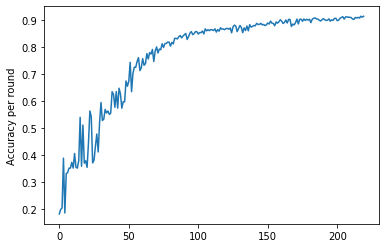

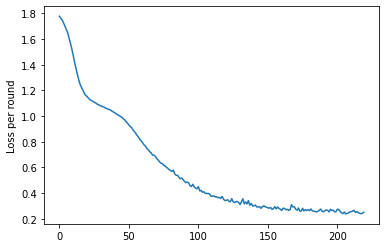

In [ ]:
#FL environment parameters
#percentage_clients_considered = .3    #percentage of clients randomly selected by central server
#percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_10, loss_history_poc_10_10, num_rounds, clients_considered_history_10_10 = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

10 clients considered and 8 selected

Starting
Before training global model accuracy = [1.814286470413208, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.9012554883956909
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  8
Number of iterations per client per round :  10
Number of rounds until convergence :  142


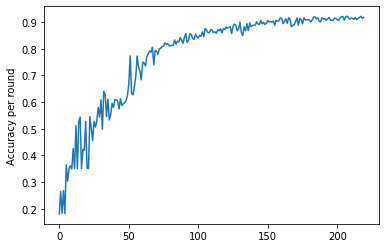

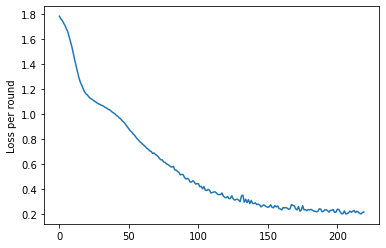

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 8 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_8, loss_history_poc_10_8, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_10_10)


**10 participating clients and 6 selected**

Starting
Before training global model accuracy = [1.8110933303833008, 0.1425178200006485]


Global model converged
Convergence accuracy score =  0.903630793094635
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  6
Number of iterations per client per round :  10
Number of rounds until convergence :  170


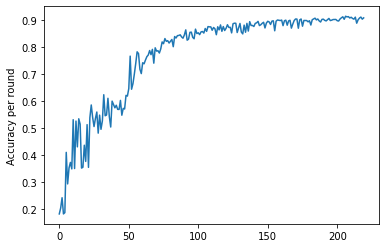

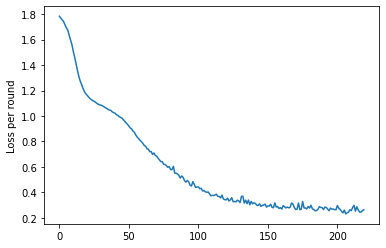

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 6 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_6, loss_history_poc_10_6, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_10_10)


10 participating clients and 4 selected

Starting
Before training global model accuracy = [1.9568488597869873, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.900237500667572
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  4
Number of iterations per client per round :  10
Number of rounds until convergence :  158


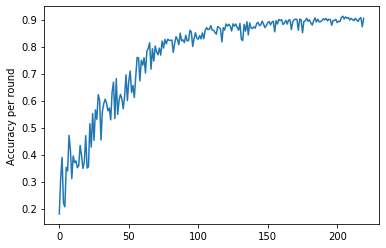

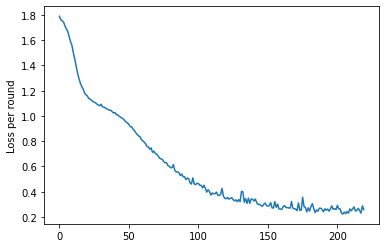

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 4 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_4, loss_history_poc_10_4, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_10_10)


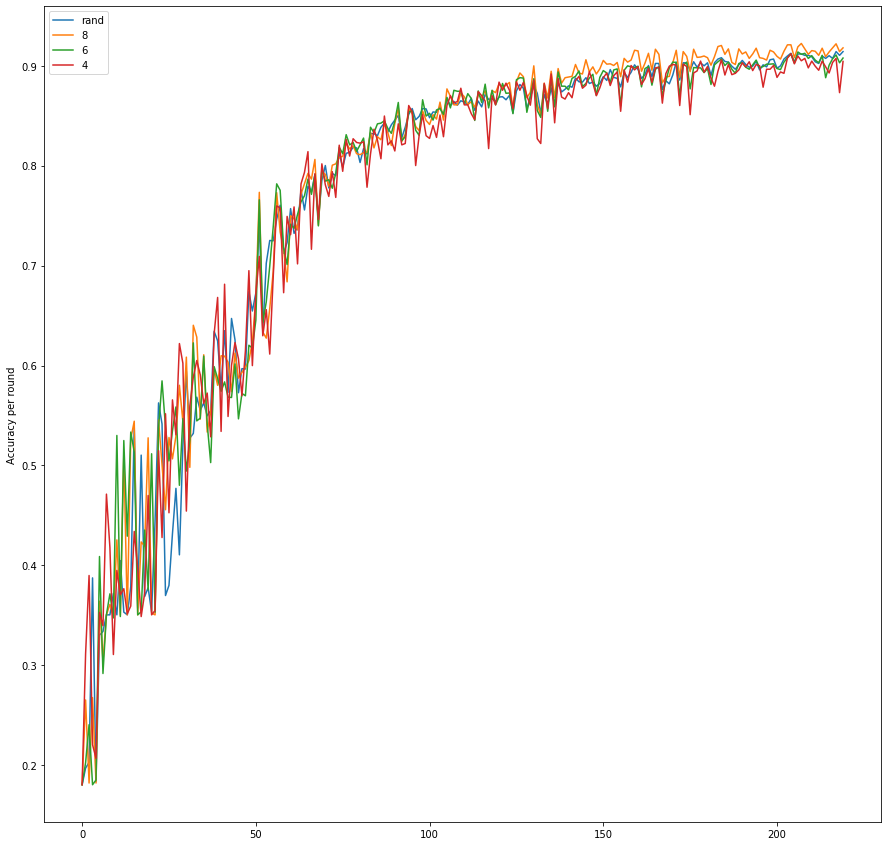

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_10)
plt.plot(accuracy_history_poc_10_8)
plt.plot(accuracy_history_poc_10_6)
plt.plot(accuracy_history_poc_10_4)
plt.ylabel('Accuracy per round')
plt.legend(["rand", "8", "6", "4"])

plt.show()

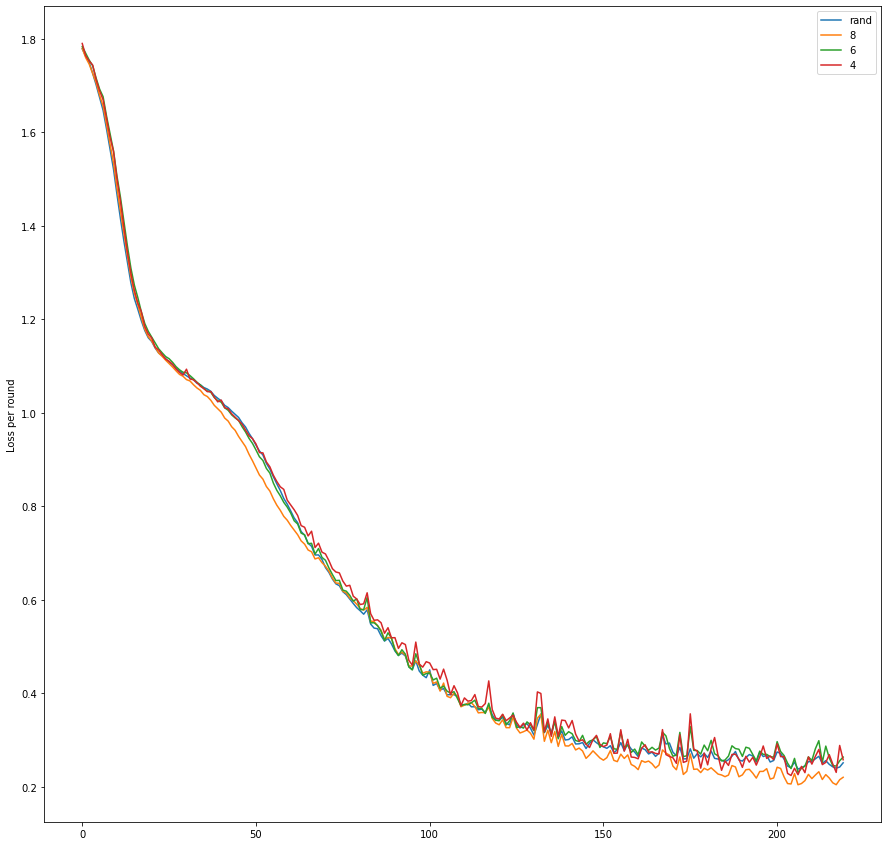

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_10_10)
plt.plot(loss_history_poc_10_8)
plt.plot(loss_history_poc_10_6)
plt.plot(loss_history_poc_10_4)
plt.ylabel('Loss per round')
plt.legend(["rand", "8", "6", "4"])

plt.show()

In [ ]:
print(accuracy_history_poc_10_10)
print(accuracy_history_poc_10_8)
print(accuracy_history_poc_10_6)
print(accuracy_history_poc_10_4)

[0.18052256107330322, 0.19714964926242828, 0.20291821658611298, 0.3875127136707306, 0.1839158535003662, 0.3301662802696228, 0.3338988721370697, 0.35052594542503357, 0.35052594542503357, 0.3719036281108856, 0.35052594542503357, 0.40481844544410706, 0.35324057936668396, 0.35052594542503357, 0.3786901831626892, 0.5388530492782593, 0.35731253027915955, 0.5103495121002197, 0.36884966492652893, 0.3776721954345703, 0.35324057936668396, 0.44485917687416077, 0.5626060366630554, 0.5415676832199097, 0.3698676526546478, 0.3800475001335144, 0.4316253960132599, 0.477095365524292, 0.41058704257011414, 0.5205293297767639, 0.5941635370254517, 0.5273159146308899, 0.5320665240287781, 0.5683746337890625, 0.5551407933235168, 0.5626060366630554, 0.5497115850448608, 0.5548014640808105, 0.6342042684555054, 0.6247031092643738, 0.5765184760093689, 0.634882926940918, 0.5731251835823059, 0.6470987200737, 0.6257210969924927, 0.5727858543395996, 0.596878170967102, 0.5965388417243958, 0.6739056706428528, 0.654563963

In [ ]:
print(loss_history_poc_10_10)
print(loss_history_poc_10_8)
print(loss_history_poc_10_6)
print(loss_history_poc_10_4)

[1.7785515785217285, 1.762514591217041, 1.7494312524795532, 1.7260960340499878, 1.7015208005905151, 1.6747866868972778, 1.6472069025039673, 1.606774091720581, 1.5642294883728027, 1.5212159156799316, 1.4670425653457642, 1.415402889251709, 1.3669624328613281, 1.3224684000015259, 1.2781643867492676, 1.2444270849227905, 1.221533179283142, 1.1972278356552124, 1.1760565042495728, 1.1606966257095337, 1.15248441696167, 1.1384077072143555, 1.1281405687332153, 1.122348666191101, 1.1161736249923706, 1.108691692352295, 1.1029075384140015, 1.095335602760315, 1.0889874696731567, 1.0841989517211914, 1.0792919397354126, 1.0744749307632446, 1.0711055994033813, 1.0634288787841797, 1.059955358505249, 1.0541749000549316, 1.0509309768676758, 1.046075701713562, 1.0371686220169067, 1.0312328338623047, 1.0256174802780151, 1.0160374641418457, 1.0112894773483276, 1.0036523342132568, 0.9969415068626404, 0.9901440739631653, 0.9787097573280334, 0.9697185158729553, 0.956167459487915, 0.9447889924049377, 0.930938363

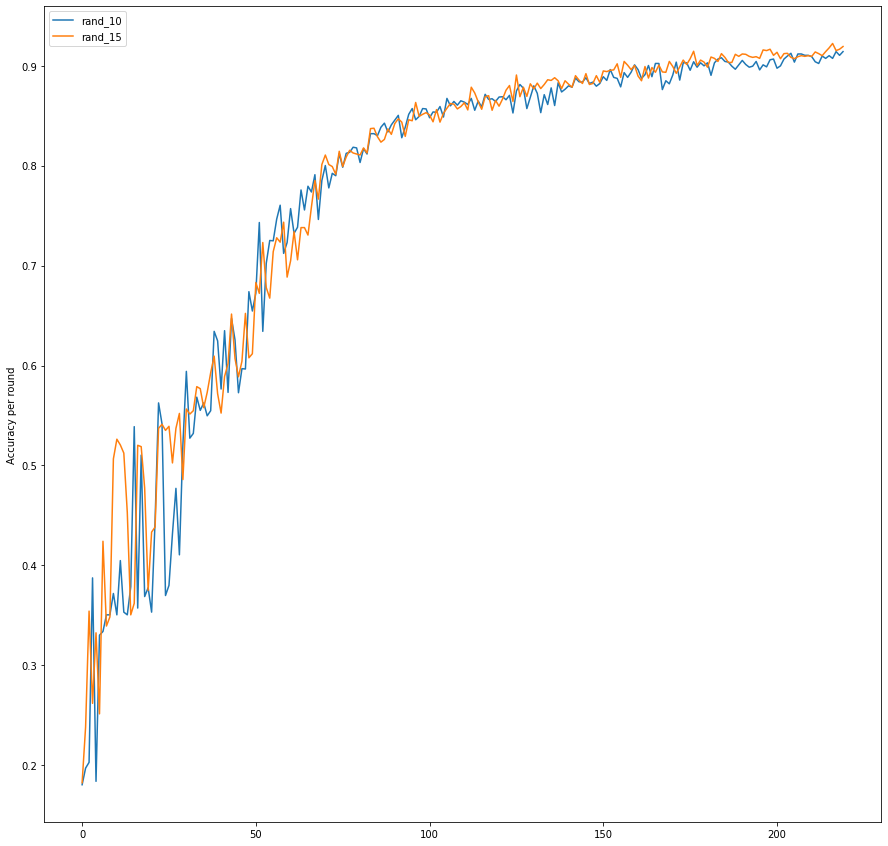

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_10)
plt.plot(accuracy_history_poc_15_15)
plt.ylabel('Accuracy per round')
plt.legend(["rand_10", "rand_15"])

plt.show()

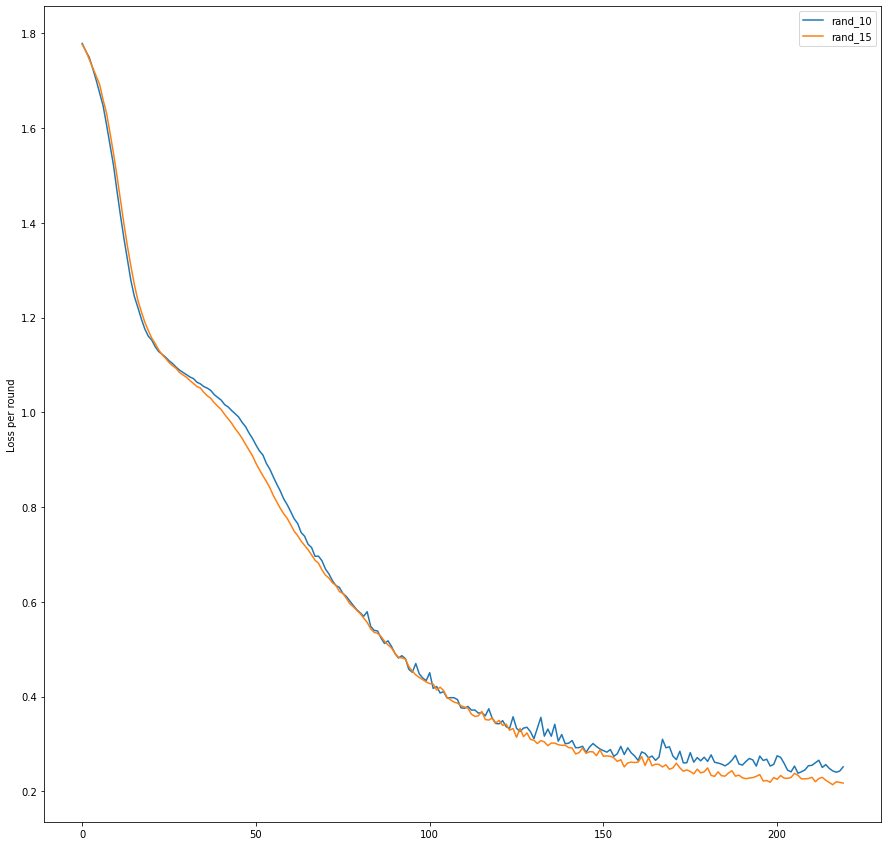

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_10_10)
plt.plot(loss_history_poc_15_15)
plt.ylabel('Loss per round')
plt.legend(["rand_10", "rand_15"])

plt.show()

Starting
Before training global model accuracy = [1.857985258102417, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.9046487808227539
Number of clients : 35
Number of clients participating per round : 5
Number of clients training the model per round :  5
Number of iterations per client per round :  10
Number of rounds until convergence :  149


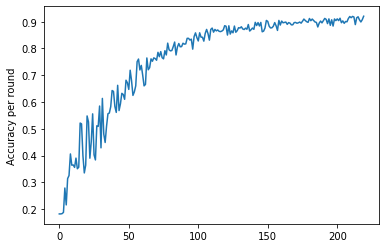

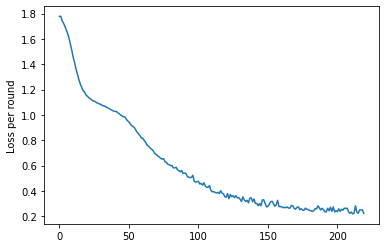

In [ ]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 5 #int(num_clients*percentage_clients_considered)
num_clients_selected = 5 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_5_5, loss_history_poc_5_5, num_rounds, clients_considered_history_5_5 = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

Starting
Before training global model accuracy = [1.899341106414795, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.9043094515800476
Number of clients : 35
Number of clients participating per round : 5
Number of clients training the model per round :  3
Number of iterations per client per round :  10
Number of rounds until convergence :  191


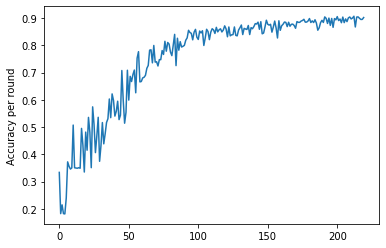

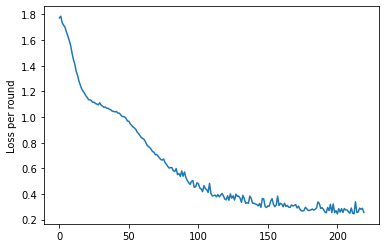

In [ ]:
#FL environment parameters
#percentage_clients_considered = .2    #percentage of clients randomly selected by central server
#percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 5 #int(num_clients*percentage_clients_considered)
num_clients_selected = 3 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_5_3, loss_history_poc_5_3, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_5_5)


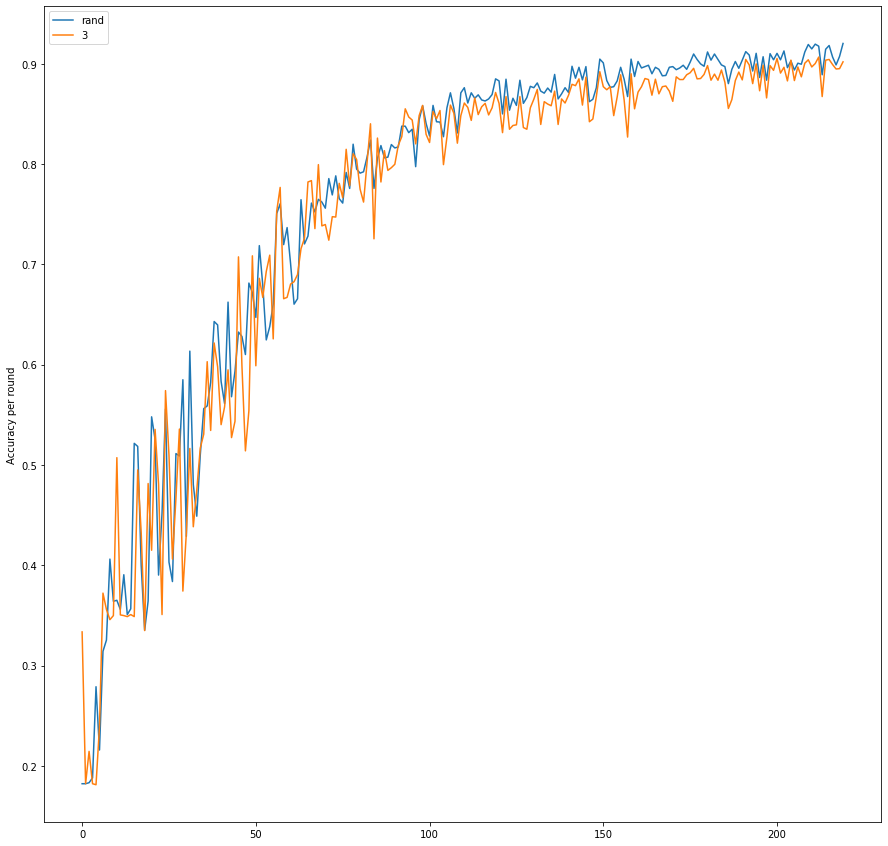

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_5_5)
plt.plot(accuracy_history_poc_5_3)
plt.ylabel('Accuracy per round')
plt.legend(["rand", "3"])

plt.show()

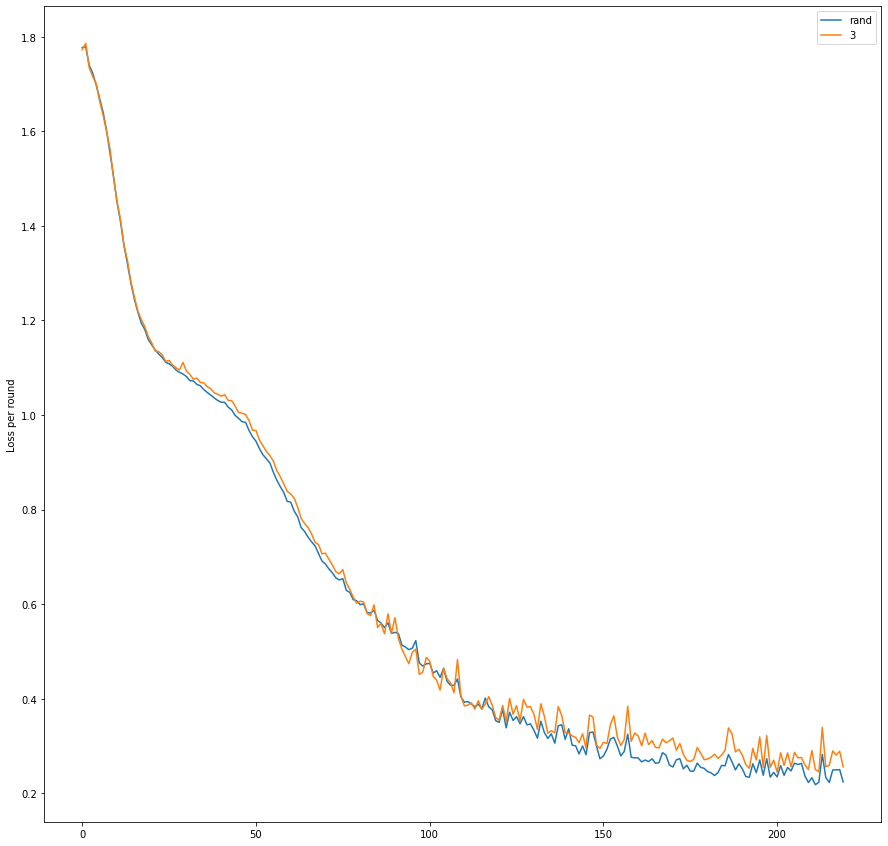

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_5_5)
plt.plot(loss_history_poc_5_3)
plt.ylabel('Loss per round')
plt.legend(["rand", "3"])

plt.show()

In [ ]:
print(accuracy_history_poc_5_5)
print(accuracy_history_poc_5_3)

[0.18221920728683472, 0.18221920728683472, 0.1832371950149536, 0.1879877895116806, 0.2789277136325836, 0.21581269800662994, 0.31421783566474915, 0.3254156708717346, 0.40617576241493225, 0.36409908533096313, 0.36511707305908203, 0.35595521330833435, 0.3905666768550873, 0.35086527466773987, 0.35663387179374695, 0.5215473175048828, 0.5184933543205261, 0.40006786584854126, 0.3352561891078949, 0.36443841457366943, 0.5480149388313293, 0.5256192684173584, 0.390227347612381, 0.45198506116867065, 0.5558194518089294, 0.40312182903289795, 0.3837801218032837, 0.5113674998283386, 0.5089921951293945, 0.5850017070770264, 0.4289107620716095, 0.6135052442550659, 0.4804886281490326, 0.44893112778663635, 0.5096708536148071, 0.5561587810516357, 0.5588734149932861, 0.582287073135376, 0.6430268287658691, 0.6396335363388062, 0.5833050608634949, 0.5612487196922302, 0.6623685359954834, 0.5680353045463562, 0.5934848785400391, 0.6325076222419739, 0.628096342086792, 0.6101119518280029, 0.6813709139823914, 0.67186

In [ ]:
print(loss_history_poc_5_5)
print(loss_history_poc_5_3)

[1.7772059440612793, 1.7790168523788452, 1.7398203611373901, 1.7233057022094727, 1.6984671354293823, 1.6694871187210083, 1.6406997442245483, 1.6017855405807495, 1.553896188735962, 1.5047013759613037, 1.4505914449691772, 1.4096943140029907, 1.359513282775879, 1.3202420473098755, 1.2790677547454834, 1.2451025247573853, 1.2176449298858643, 1.194136142730713, 1.1808953285217285, 1.1596485376358032, 1.1483784914016724, 1.137550711631775, 1.1290208101272583, 1.1217578649520874, 1.1116433143615723, 1.1085362434387207, 1.103023648262024, 1.094977617263794, 1.090314269065857, 1.086596131324768, 1.081294298171997, 1.0726752281188965, 1.071993112564087, 1.064723253250122, 1.0618075132369995, 1.0537832975387573, 1.0475400686264038, 1.0421104431152344, 1.035976529121399, 1.0307401418685913, 1.0270226001739502, 1.0268441438674927, 1.0166860818862915, 1.0108472108840942, 0.9992174506187439, 0.9929627776145935, 0.9857057929039001, 0.9846463799476624, 0.9674288034439087, 0.9538558721542358, 0.944662809

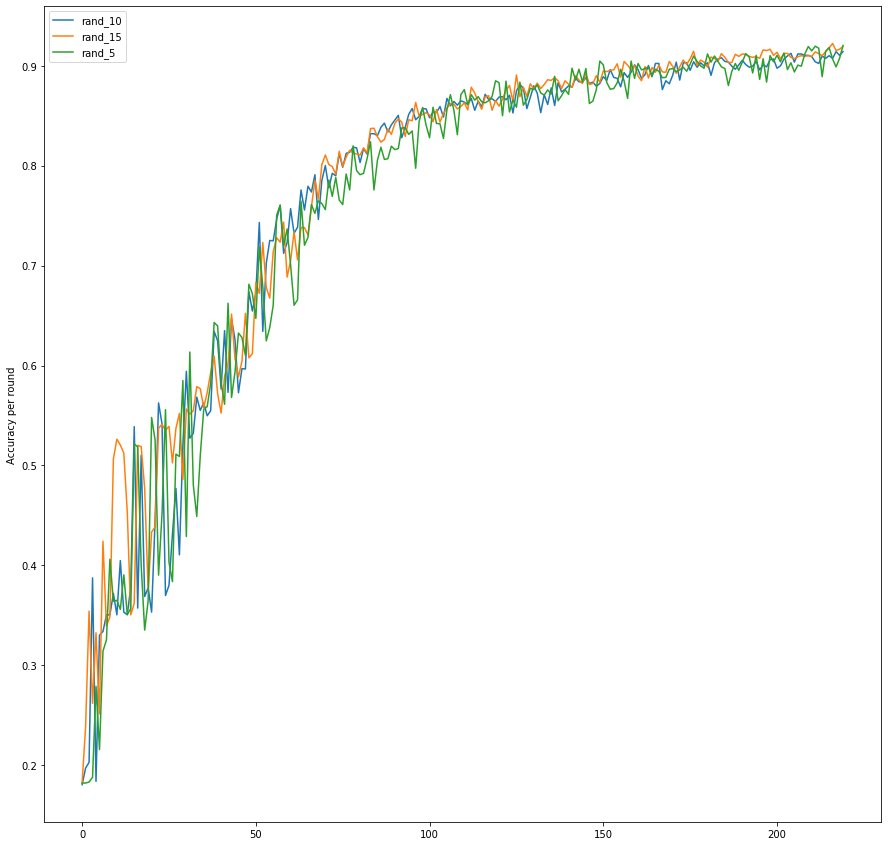

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_10)
plt.plot(accuracy_history_poc_15_15)
plt.plot(accuracy_history_poc_5_5)
plt.ylabel('Accuracy per round')
plt.legend(["rand_10", "rand_15", "rand_5"])

plt.show()

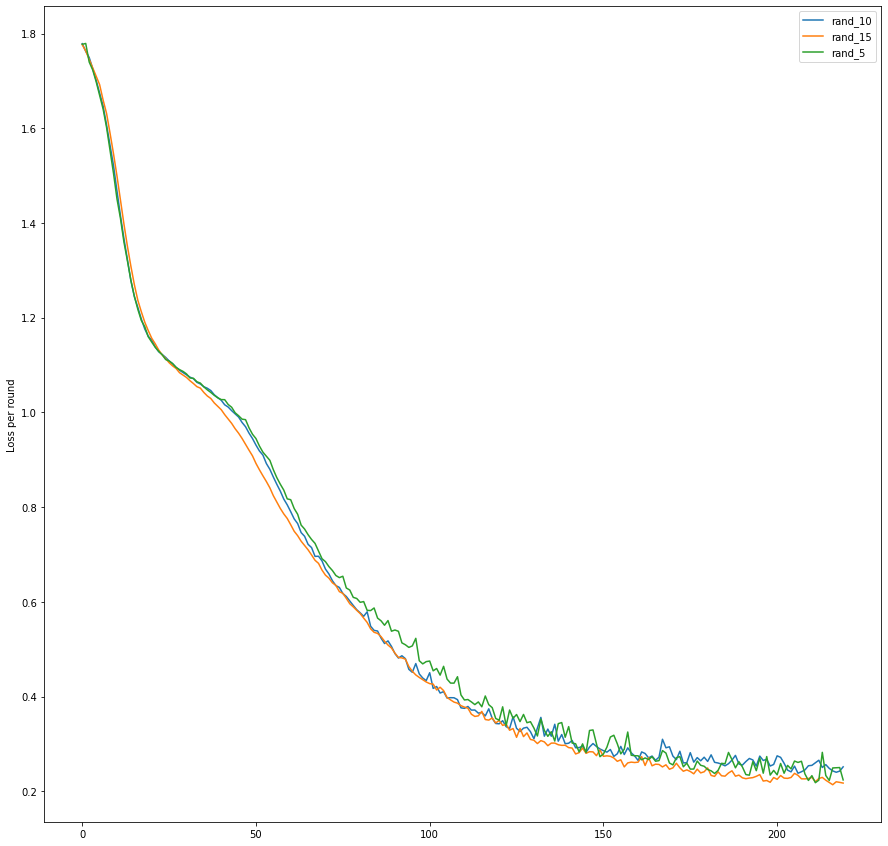

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_10_10)
plt.plot(loss_history_poc_15_15)
plt.plot(loss_history_poc_5_5)
plt.ylabel('Loss per round')
plt.legend(["rand_10", "rand_15", "rand_5"])

plt.show()

### **Power-of-Choice, iterations = 20**

In [ ]:
num_iterations_per_round = 20

Starting
Before training global model accuracy = [2.0622527599334717, 0.18221920728683472]


Global model converged
Convergence accuracy score =  0.9056667685508728
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  10
Number of iterations per client per round :  20
Number of rounds until convergence :  75


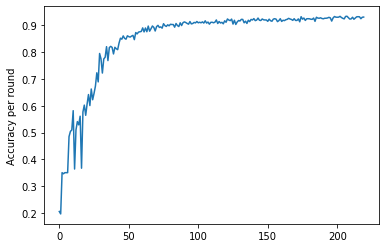

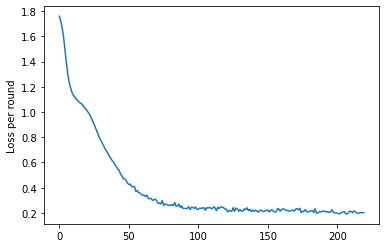

In [ ]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc, loss_history_poc, num_rounds, clients_considered_history = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

Starting
Before training global model accuracy = [2.185544729232788, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.9039701223373413
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  8
Number of iterations per client per round :  20
Number of rounds until convergence :  94


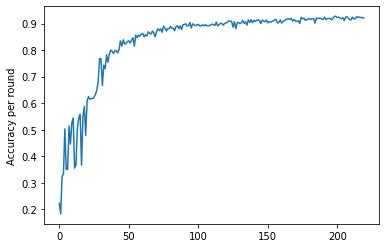

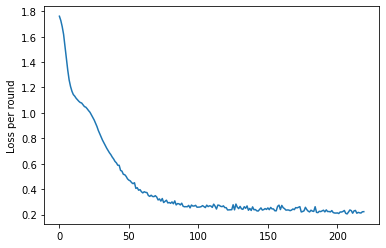

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 8 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_8, loss_history_poc_15_8, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


Starting
Before training global model accuracy = [2.5594120025634766, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.9053274393081665
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  4
Number of iterations per client per round :  20
Number of rounds until convergence :  84


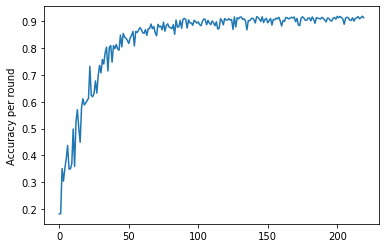

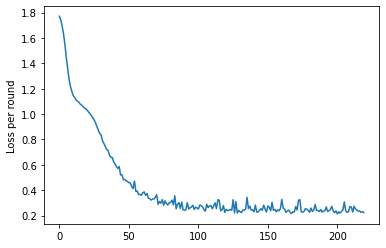

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 4 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_4, loss_history_poc_15_4, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


Starting
Before training global model accuracy = [2.0789666175842285, 0.16830675303936005]


Global model converged
Convergence accuracy score =  0.9077027440071106
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  15
Number of iterations per client per round :  20
Number of rounds until convergence :  76


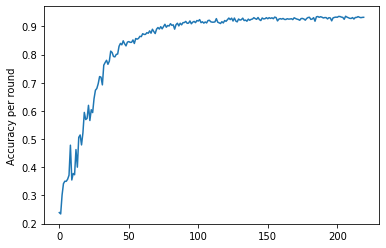

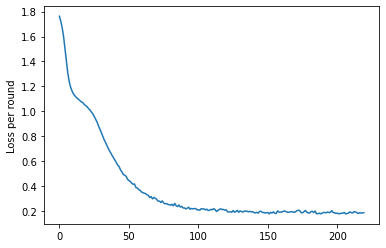

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 15 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_15, loss_history_poc_15_15, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


Starting
Before training global model accuracy = [2.098235845565796, 0.18052256107330322]


Global model converged
Convergence accuracy score =  0.9073634147644043
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  6
Number of iterations per client per round :  20
Number of rounds until convergence :  75


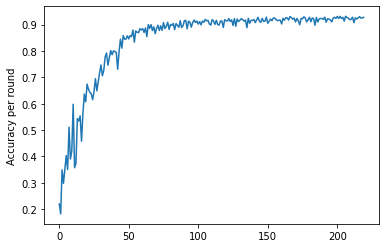

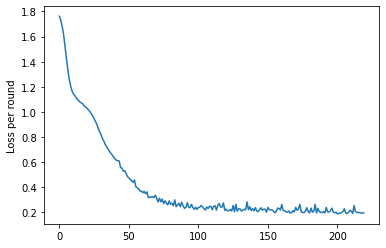

In [ ]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 6 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_6, loss_history_poc_15_6, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


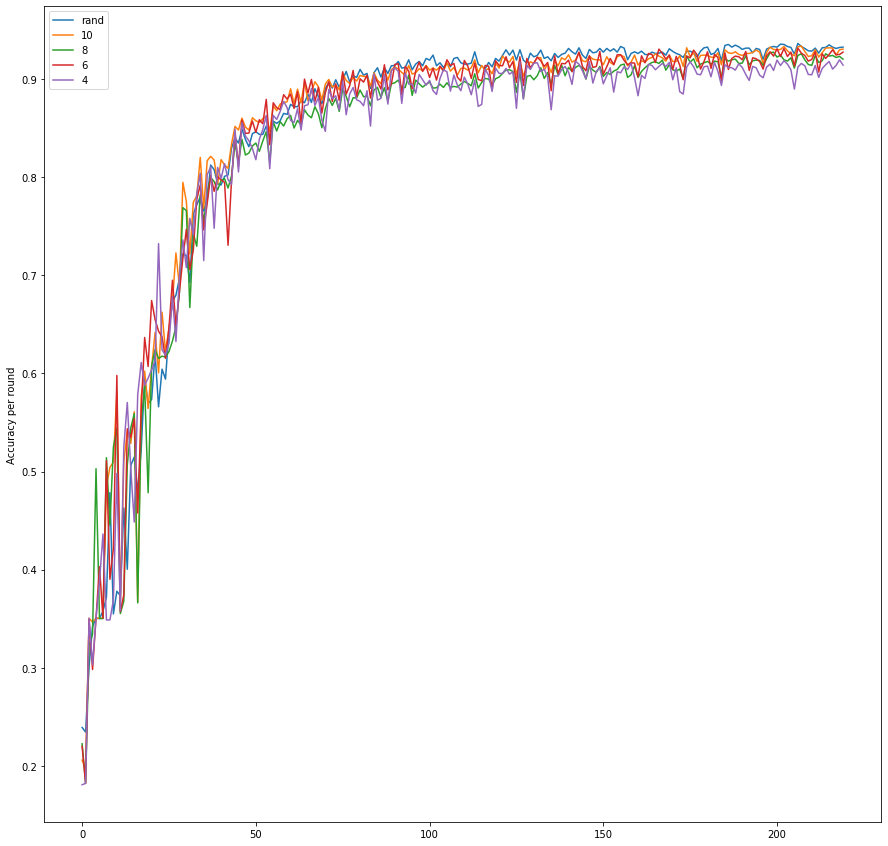

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_15_15)
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history_poc_15_8)
plt.plot(accuracy_history_poc_15_6)
plt.plot(accuracy_history_poc_15_4)
plt.ylabel('Accuracy per round')
plt.legend(["rand","10", "8", "6", "4"])

plt.show()

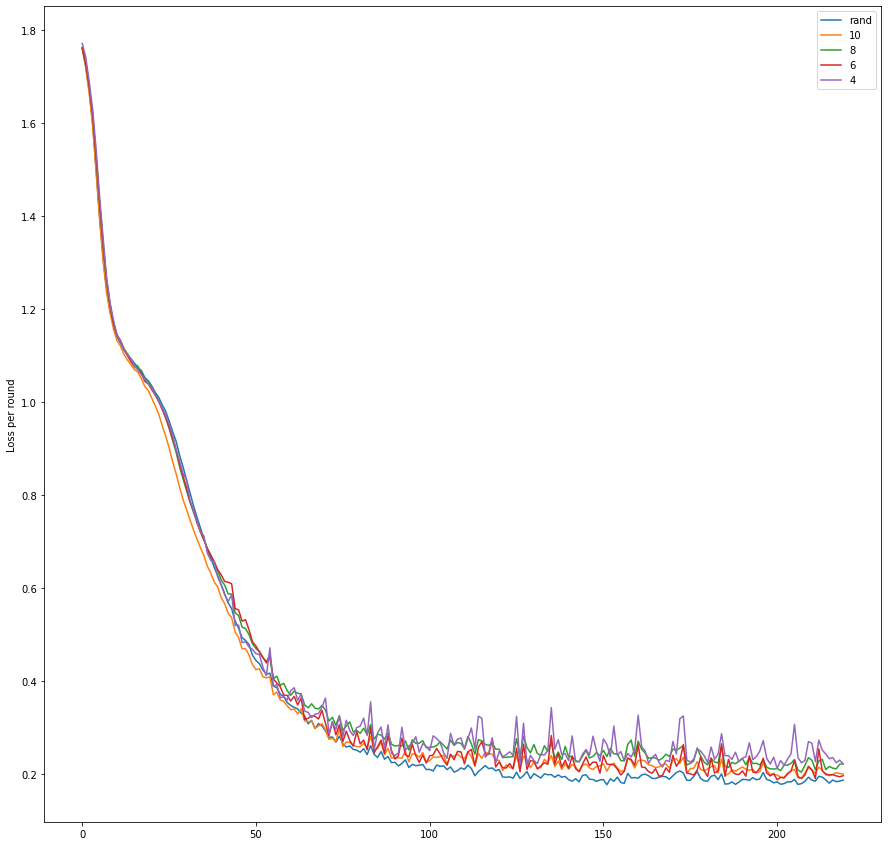

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_15_15)
plt.plot(loss_history_poc)
plt.plot(loss_history_poc_15_8)
plt.plot(loss_history_poc_15_6)
plt.plot(loss_history_poc_15_4)
plt.ylabel('Loss per round')
plt.legend(["rand","10", "8", "6", "4"])

plt.show()

In [ ]:
print(accuracy_history_poc)
print(accuracy_history_poc_15_15)
print(accuracy_history_poc_15_8)
print(accuracy_history_poc_15_6)
print(accuracy_history_poc_15_4)

[0.20597217977046967, 0.19681032001972198, 0.35052594542503357, 0.34645402431488037, 0.35052594542503357, 0.35052594542503357, 0.35052594542503357, 0.4848999083042145, 0.5042415857315063, 0.5096708536148071, 0.5816084146499634, 0.36409908533096313, 0.5096708536148071, 0.5408890247344971, 0.5286732316017151, 0.5609093904495239, 0.3671530485153198, 0.5765184760093689, 0.6023074388504028, 0.5643026828765869, 0.6060400605201721, 0.641669511795044, 0.6006107926368713, 0.6623685359954834, 0.6223278045654297, 0.646080732345581, 0.6732270121574402, 0.7227689027786255, 0.6888360977172852, 0.7947064638137817, 0.7750254273414612, 0.7217509150505066, 0.7743467688560486, 0.7807940244674683, 0.8201560974121094, 0.76823890209198, 0.8167628049850464, 0.8211740851402283, 0.817441463470459, 0.7930098176002502, 0.8177807927131653, 0.8123515248298645, 0.8089582920074463, 0.8337292075157166, 0.8517135977745056, 0.8479809761047363, 0.8601968288421631, 0.851034939289093, 0.8479809761047363, 0.860536158084869

In [ ]:
print(loss_history_poc)
print(loss_history_poc_15_15)
print(loss_history_poc_15_8)
print(loss_history_poc_15_6)
print(loss_history_poc_15_4)

[1.7587504386901855, 1.7192498445510864, 1.6638429164886475, 1.5941259860992432, 1.492749810218811, 1.3925576210021973, 1.3050981760025024, 1.235717535018921, 1.192343831062317, 1.1566581726074219, 1.1325193643569946, 1.1208763122558594, 1.103045105934143, 1.0909768342971802, 1.0810456275939941, 1.0702284574508667, 1.0645878314971924, 1.0513123273849487, 1.0338267087936401, 1.0253069400787354, 1.0090088844299316, 0.9924137592315674, 0.9748766422271729, 0.9502291083335876, 0.9276372194290161, 0.902070939540863, 0.8729230165481567, 0.8471483588218689, 0.8176908493041992, 0.7913165092468262, 0.7696625590324402, 0.7471096515655518, 0.7260442972183228, 0.7063665390014648, 0.6874349117279053, 0.6704685688018799, 0.6476004719734192, 0.6327297687530518, 0.6134215593338013, 0.6026264429092407, 0.5797243714332581, 0.5667407512664795, 0.545979380607605, 0.5370005965232849, 0.5062369704246521, 0.4940844476222992, 0.46994492411613464, 0.47008222341537476, 0.45654329657554626, 0.43590521812438965, 0

### **Power-of-Choice Selection with dataset subdivided by subject in original dataframe**

Starting
Before training global model accuracy = [2.148366689682007, 0.16661010682582855]


Global model converged
Convergence accuracy score =  0.9029521346092224
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  5
Number of iterations per client per round :  10
Number of rounds until convergence :  106


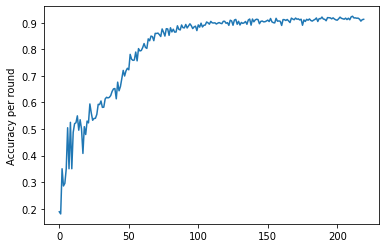

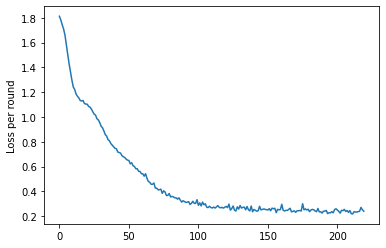

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 5 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 180

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObjectPerPerson(df_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc, loss_history_poc, num_rounds, clients_considered_history = runTrainingNoCompression(initial_global_model, accuracy_score_target , clients_dataset)

In [ ]:
print(accuracy_history_poc)
print(loss_history_poc)

[0.188666433095932, 0.18052256107330322, 0.35052594542503357, 0.2857142984867096, 0.2955547869205475, 0.35018661618232727, 0.504920244216919, 0.35052594542503357, 0.5252799391746521, 0.35052594542503357, 0.4872751832008362, 0.5201900005340576, 0.5239226222038269, 0.5497115850448608, 0.49575838446617126, 0.5351204872131348, 0.49983033537864685, 0.40821173787117004, 0.5089921951293945, 0.4794706404209137, 0.5300305485725403, 0.5232439637184143, 0.594502866268158, 0.5609093904495239, 0.533084511756897, 0.5398710370063782, 0.5405496954917908, 0.5551407933235168, 0.5931455492973328, 0.5921275615692139, 0.6057007312774658, 0.5816084146499634, 0.582287073135376, 0.6131659150123596, 0.6196131706237793, 0.6172378659248352, 0.619273841381073, 0.626060426235199, 0.641669511795044, 0.6511706709861755, 0.6525279879570007, 0.6138445734977722, 0.6766203045845032, 0.644044816493988, 0.6603325605392456, 0.690872073173523, 0.7207329273223877, 0.6996946334838867, 0.7190362811088562, 0.7288768291473389, 0

In [ ]:
print(clients_considered_history)

[[{'clientID': 15, 'accuracy': 0.15892420709133148}, {'clientID': 7, 'accuracy': 0.16718266904354095}, {'clientID': 3, 'accuracy': 0.16923077404499054}, {'clientID': 10, 'accuracy': 0.17391304671764374}, {'clientID': 14, 'accuracy': 0.1827957034111023}, {'clientID': 17, 'accuracy': 0.18617020547389984}, {'clientID': 18, 'accuracy': 0.1884816735982895}, {'clientID': 13, 'accuracy': 0.19314642250537872}, {'clientID': 16, 'accuracy': 0.19897958636283875}, {'clientID': 11, 'accuracy': 0.20277777314186096}], [{'clientID': 6, 'accuracy': 0.15506328642368317}, {'clientID': 4, 'accuracy': 0.1753246784210205}, {'clientID': 14, 'accuracy': 0.1854838728904724}, {'clientID': 1, 'accuracy': 0.19648094475269318}, {'clientID': 16, 'accuracy': 0.2091836780309677}, {'clientID': 10, 'accuracy': 0.21195651590824127}, {'clientID': 13, 'accuracy': 0.22429905831813812}, {'clientID': 11, 'accuracy': 0.22499999403953552}, {'clientID': 12, 'accuracy': 0.23284313082695007}, {'clientID': 17, 'accuracy': 0.273936

**Runnning experiment with compression**

Starting
Before training global model accuracy = [2.041134834289551, 0.18052256107330322]

Creating CSVEC Table
   Columns: 60000
   Rows: 3
   Compression: 0.6498241864562199

Global model converged
Convergence accuracy score =  0.9009161591529846
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  5
Number of iterations per client per round :  10
Number of rounds until convergence :  109


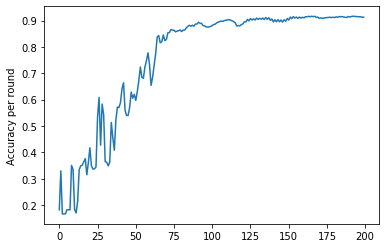

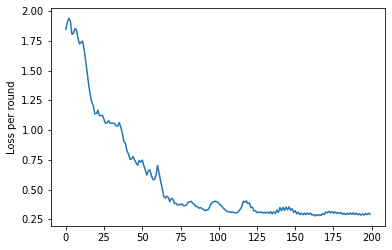

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 5 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObjectPerPerson(df_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_5, loss_history_poc_10_5, num_rounds, clients_considered_history = runTrainingWithCompression(initial_global_model, accuracy_score_target , clients_dataset)

Starting
Before training global model accuracy = [1.9391207695007324, 0.2863929271697998]

Creating CSVEC Table
   Columns: 60000
   Rows: 3
   Compression: 0.6498241864562199

Global model converged
Convergence accuracy score =  0.9026128053665161
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  3
Number of iterations per client per round :  10
Number of rounds until convergence :  113


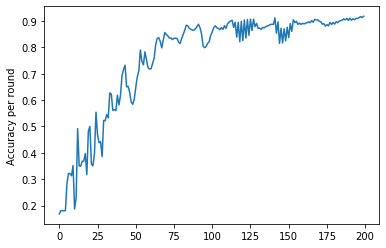

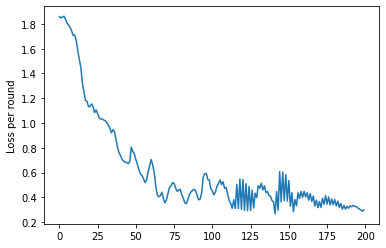

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 3 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObjectPerPerson(df_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_3, loss_history_poc_10_3, num_rounds = repeatExperimentWithCompression(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


In [ ]:
#with compression
print(accuracy_history_poc_10_3)
print(loss_history_poc_10_3)


[0.16830675303936005, 0.18052256107330322, 0.18052256107330322, 0.18052256107330322, 0.18052256107330322, 0.2829996645450592, 0.322022408246994, 0.3213437497615814, 0.31286054849624634, 0.35188326239585876, 0.1869698017835617, 0.22870716452598572, 0.49168646335601807, 0.35018661618232727, 0.34950798749923706, 0.3681710362434387, 0.36851033568382263, 0.39735323190689087, 0.31727179884910583, 0.4815066158771515, 0.5001696348190308, 0.35731253027915955, 0.35052594542503357, 0.396335244178772, 0.5541228652000427, 0.4679335057735443, 0.4380726218223572, 0.4421445429325104, 0.3854767680168152, 0.522904634475708, 0.5215473175048828, 0.5449609756469727, 0.5327451825141907, 0.6267390847206116, 0.6230064630508423, 0.5612487196922302, 0.5636240243911743, 0.559891402721405, 0.6182558536529541, 0.5816084146499634, 0.6172378659248352, 0.6925687193870544, 0.7159823775291443, 0.7322701215744019, 0.6501526832580566, 0.6521886587142944, 0.6301323175430298, 0.5924668908119202, 0.5839837193489075, 0.60298

Starting
Before training global model accuracy = [2.0448286533355713, 0.16830675303936005]

Creating CSVEC Table
   Columns: 60000
   Rows: 3
   Compression: 0.6498241864562199

Global model converged
Convergence accuracy score =  0.9015948176383972
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  7
Number of iterations per client per round :  10
Number of rounds until convergence :  111


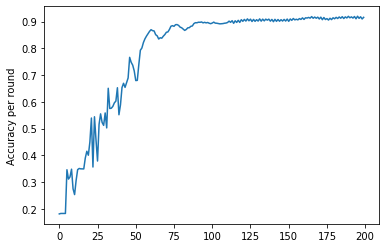

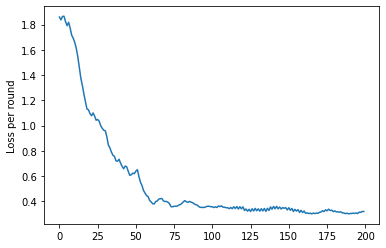

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 7 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObjectPerPerson(df_train)


initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_7, loss_history_poc_10_7, num_rounds = repeatExperimentWithCompression(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


In [ ]:
#with compression
print(accuracy_history_poc_10_7)
print(loss_history_poc_10_7)

[0.18052256107330322, 0.18221920728683472, 0.18221920728683472, 0.18221920728683472, 0.18221920728683472, 0.3457753658294678, 0.31082457304000854, 0.31896844506263733, 0.34781134128570557, 0.2745164632797241, 0.25279945135116577, 0.30573463439941406, 0.3461146950721741, 0.35052594542503357, 0.34916865825653076, 0.34882932901382446, 0.34882932901382446, 0.3895486891269684, 0.41499829292297363, 0.40006786584854126, 0.44960978627204895, 0.5391923785209656, 0.35595521330833435, 0.5439429879188538, 0.45741432905197144, 0.3783508539199829, 0.5154394507408142, 0.5548014640808105, 0.5225653052330017, 0.5117068290710449, 0.5581947565078735, 0.5022056102752686, 0.6504920125007629, 0.5748218297958374, 0.5758398175239563, 0.5826264023780823, 0.5958601832389832, 0.6026467680931091, 0.6525279879570007, 0.5514082312583923, 0.5883949995040894, 0.6532066464424133, 0.6691550612449646, 0.6538853049278259, 0.671869695186615, 0.6891754269599915, 0.7662029266357422, 0.7475398778915405, 0.7370206713676453, 0

Starting
Before training global model accuracy = [2.077643871307373, 0.16830675303936005]

Creating CSVEC Table
   Columns: 60000
   Rows: 3
   Compression: 0.6498241864562199

Global model converged
Convergence accuracy score =  0.9012554883956909
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  10
Number of iterations per client per round :  10
Number of rounds until convergence :  108


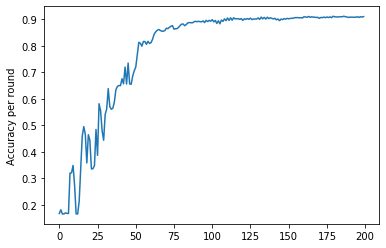

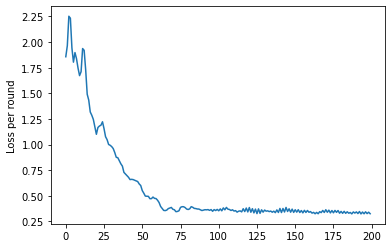

In [ ]:
#wrong 

In [ ]:
#with compression
print(accuracy_history_poc_10_10)
print(loss_history_poc_10_10)

**Reapeating the same experiments as above with same clients at each round, without compression**

In [ ]:
print(clients_considered_history)

[[{'clientID': 6, 'accuracy': 0.1487341821193695}, {'clientID': 0, 'accuracy': 0.15273775160312653}, {'clientID': 20, 'accuracy': 0.15404699742794037}, {'clientID': 3, 'accuracy': 0.17538461089134216}, {'clientID': 14, 'accuracy': 0.1827957034111023}, {'clientID': 2, 'accuracy': 0.18543046712875366}, {'clientID': 19, 'accuracy': 0.1889534890651703}, {'clientID': 5, 'accuracy': 0.19217081367969513}, {'clientID': 18, 'accuracy': 0.20680628716945648}, {'clientID': 17, 'accuracy': 0.21276596188545227}], [{'clientID': 0, 'accuracy': 0.14409221708774567}, {'clientID': 2, 'accuracy': 0.17218543589115143}, {'clientID': 3, 'accuracy': 0.17538461089134216}, {'clientID': 6, 'accuracy': 0.1803797483444214}, {'clientID': 20, 'accuracy': 0.18276762962341309}, {'clientID': 14, 'accuracy': 0.19354838132858276}, {'clientID': 16, 'accuracy': 0.19387754797935486}, {'clientID': 17, 'accuracy': 0.19680851697921753}, {'clientID': 19, 'accuracy': 0.2005814015865326}, {'clientID': 8, 'accuracy': 0.21951219439

Starting
Before training global model accuracy = [2.531963348388672, 0.16830675303936005]


Global model converged
Convergence accuracy score =  0.9063454270362854
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  10
Number of iterations per client per round :  10
Number of rounds until convergence :  97


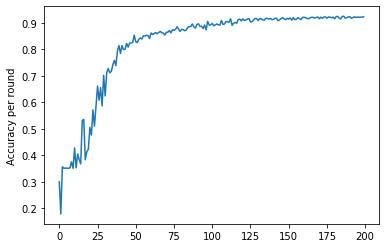

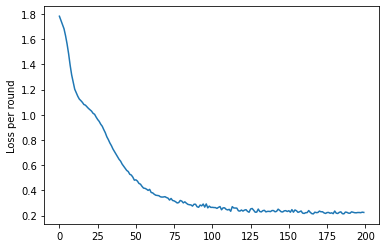

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_10_no_compression, loss_history_poc_10_10_no_compression, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


In [ ]:
print(accuracy_history_poc_10_10_no_compression)
print(loss_history_poc_10_10_no_compression)

[0.2992874085903168, 0.17814727127552032, 0.35629454255104065, 0.35052594542503357, 0.35154393315315247, 0.35120460391044617, 0.35052594542503357, 0.35222259163856506, 0.3749575912952423, 0.35052594542503357, 0.427214115858078, 0.35256192088127136, 0.40447914600372314, 0.38411945104599, 0.3671530485153198, 0.5303698778152466, 0.5354598164558411, 0.3827621340751648, 0.41364097595214844, 0.4224635362625122, 0.5052595734596252, 0.4760773777961731, 0.5714285969734192, 0.5096708536148071, 0.5873770117759705, 0.6613505482673645, 0.6080760359764099, 0.6552426218986511, 0.5866983532905579, 0.702069878578186, 0.6240244507789612, 0.712249755859375, 0.72785884141922, 0.7115710973739624, 0.7166610360145569, 0.7414319515228271, 0.7587376832962036, 0.7390566468238831, 0.7936884760856628, 0.8143875002861023, 0.7848659753799438, 0.8143875002861023, 0.7991177439689636, 0.8004750609397888, 0.8225314021110535, 0.8089582920074463, 0.8238887190818787, 0.8245673775672913, 0.8262640237808228, 0.8537495732307

Starting
Before training global model accuracy = [1.8966487646102905, 0.15982355177402496]


Global model converged
Convergence accuracy score =  0.9012554883956909
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  5
Number of iterations per client per round :  10
Number of rounds until convergence :  91


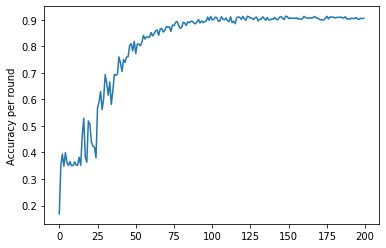

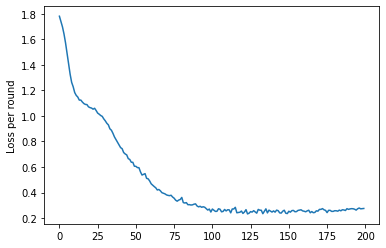

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 5 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_5_no_compression, loss_history_poc_10_5_no_compression, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


In [ ]:
print(accuracy_history_poc_10_5_no_compression)
print(loss_history_poc_10_5_no_compression)

[0.16830675303936005, 0.35052594542503357, 0.39429929852485657, 0.34815067052841187, 0.39938920736312866, 0.36240243911743164, 0.35052594542503357, 0.36579573154449463, 0.34984731674194336, 0.35052594542503357, 0.36409908533096313, 0.35222259163856506, 0.35222259163856506, 0.3817441463470459, 0.35120460391044617, 0.46284356713294983, 0.5286732316017151, 0.3831014633178711, 0.36308109760284424, 0.5184933543205261, 0.5069562196731567, 0.4387512803077698, 0.4234814941883087, 0.4200882315635681, 0.3793688416481018, 0.5673566460609436, 0.5904309749603271, 0.6297929883003235, 0.5612487196922302, 0.6033254265785217, 0.693247377872467, 0.6606718897819519, 0.61588054895401, 0.6661010980606079, 0.5809297561645508, 0.6321682929992676, 0.6942653656005859, 0.690872073173523, 0.6952833533287048, 0.7600950002670288, 0.7373600006103516, 0.7051238417625427, 0.7502545118331909, 0.7393959760665894, 0.7597556710243225, 0.7611129879951477, 0.8031896948814392, 0.8099762201309204, 0.7824906706809998, 0.81913

Starting
Before training global model accuracy = [2.0004465579986572, 0.1425178200006485]


Global model converged
Convergence accuracy score =  0.9080420732498169
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  3
Number of iterations per client per round :  10
Number of rounds until convergence :  91


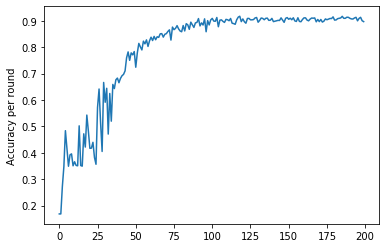

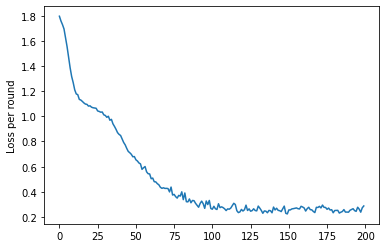

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 3 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_3_no_compression, loss_history_poc_10_3_no_compression, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


In [ ]:
print(accuracy_history_poc_10_3_no_compression)
print(loss_history_poc_10_3_no_compression)

[0.16830675303936005, 0.16830675303936005, 0.27180182933807373, 0.34781134128570557, 0.4835425913333893, 0.41635560989379883, 0.34882932901382446, 0.3919239938259125, 0.3956565856933594, 0.35052594542503357, 0.36579573154449463, 0.35188326239585876, 0.35052594542503357, 0.5018662810325623, 0.35154393315315247, 0.34916865825653076, 0.4716660976409912, 0.4214455485343933, 0.5425856709480286, 0.4825246036052704, 0.4166949391365051, 0.4173735976219177, 0.4394299387931824, 0.3820834755897522, 0.35629454255104065, 0.5714285969734192, 0.6413301825523376, 0.5134034752845764, 0.40481844544410706, 0.6661010980606079, 0.591109573841095, 0.644044816493988, 0.4706481099128723, 0.6243637800216675, 0.519511342048645, 0.6586359143257141, 0.6430268287658691, 0.6762809753417969, 0.6827281713485718, 0.665083110332489, 0.6813709139823914, 0.6915507316589355, 0.69664067029953, 0.7098744511604309, 0.7597556710243225, 0.7818120121955872, 0.7499151825904846, 0.7780793905258179, 0.7706142067909241, 0.783169329

Starting
Before training global model accuracy = [1.955411672592163, 0.1425178200006485]


Global model converged
Convergence accuracy score =  0.9097387194633484
Number of clients : 21
Number of clients participating per round : 10
Number of clients training the model per round :  7
Number of iterations per client per round :  10
Number of rounds until convergence :  91


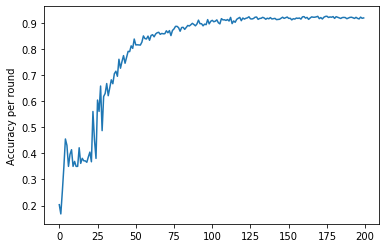

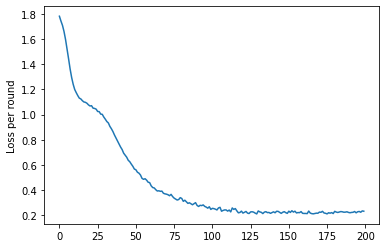

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 7 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 200

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_7_no_compression, loss_history_poc_10_7_no_compression, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


In [ ]:
print(accuracy_history_poc_10_7_no_compression)
print(loss_history_poc_10_7_no_compression)

[0.20359687507152557, 0.16830675303936005, 0.25483542680740356, 0.34916865825653076, 0.45503902435302734, 0.430607408285141, 0.35018661618232727, 0.3959959149360657, 0.41398030519485474, 0.35018661618232727, 0.36918899416923523, 0.35018661618232727, 0.35018661618232727, 0.4214455485343933, 0.36172378063201904, 0.3810654878616333, 0.3715642988681793, 0.371224969625473, 0.36579573154449463, 0.3864947259426117, 0.40481844544410706, 0.3678317070007324, 0.5602307319641113, 0.45130640268325806, 0.380726158618927, 0.6040040850639343, 0.5605700612068176, 0.6576179265975952, 0.4869358539581299, 0.6175771951675415, 0.6294536590576172, 0.6671190857887268, 0.6206311583518982, 0.6518493294715881, 0.6813709139823914, 0.6664404273033142, 0.7047845125198364, 0.7142857313156128, 0.6949440240859985, 0.7600950002670288, 0.7258228659629822, 0.7516118288040161, 0.7740074396133423, 0.7448252439498901, 0.7675602436065674, 0.7902952432632446, 0.7892772555351257, 0.8113335371017456, 0.801832377910614, 0.837461

### **Result analyses**

In [ ]:
accuracy_history_poc_10_7_no_compression = [0.20359687507152557, 0.16830675303936005, 0.25483542680740356, 0.34916865825653076, 0.45503902435302734, 0.430607408285141, 0.35018661618232727, 0.3959959149360657, 0.41398030519485474, 0.35018661618232727, 0.36918899416923523, 0.35018661618232727, 0.35018661618232727, 0.4214455485343933, 0.36172378063201904, 0.3810654878616333, 0.3715642988681793, 0.371224969625473, 0.36579573154449463, 0.3864947259426117, 0.40481844544410706, 0.3678317070007324, 0.5602307319641113, 0.45130640268325806, 0.380726158618927, 0.6040040850639343, 0.5605700612068176, 0.6576179265975952, 0.4869358539581299, 0.6175771951675415, 0.6294536590576172, 0.6671190857887268, 0.6206311583518982, 0.6518493294715881, 0.6813709139823914, 0.6664404273033142, 0.7047845125198364, 0.7142857313156128, 0.6949440240859985, 0.7600950002670288, 0.7258228659629822, 0.7516118288040161, 0.7740074396133423, 0.7448252439498901, 0.7675602436065674, 0.7902952432632446, 0.7892772555351257, 0.8113335371017456, 0.801832377910614, 0.8374618291854858, 0.8150661587715149, 0.8154054880142212, 0.8147268295288086, 0.8143875002861023, 0.8255853652954102, 0.8493382930755615, 0.8391584753990173, 0.8378011584281921, 0.8486596345901489, 0.8327112197875977, 0.851034939289093, 0.8540889024734497, 0.8459450006484985, 0.8568035364151001, 0.8615541458129883, 0.8632507920265198, 0.8554462194442749, 0.8588395118713379, 0.8574821949005127, 0.857821524143219, 0.8690193295478821, 0.8615541458129883, 0.8696979880332947, 0.8506956100463867, 0.8703766465187073, 0.8761452436447144, 0.8859857320785522, 0.8859857320785522, 0.8808958530426025, 0.8673226833343506, 0.8815745115280151, 0.882253110408783, 0.8744485974311829, 0.8819137811660767, 0.8893790245056152, 0.8873430490493774, 0.8920936584472656, 0.8975229263305664, 0.8931116461753845, 0.88802170753479, 0.8951476216316223, 0.9097387194633484, 0.8961656093597412, 0.8961656093597412, 0.88802170753479, 0.8944689631462097, 0.8924329876899719, 0.9117746949195862, 0.8954869508743286, 0.9053274393081665, 0.9090600609779358, 0.903630793094635, 0.9056667685508728, 0.9107567071914673, 0.8998982310295105, 0.8954869508743286, 0.9155073165893555, 0.9107567071914673, 0.9110960364341736, 0.9087207317352295, 0.9121140241622925, 0.9063454270362854, 0.9202578663825989, 0.8965049386024475, 0.9066847562789917, 0.9015948176383972, 0.9127926826477051, 0.9168646335601807, 0.9202578663825989, 0.9077027440071106, 0.9178826212882996, 0.913810670375824, 0.9168646335601807, 0.9185612201690674, 0.922633171081543, 0.9148286581039429, 0.9141499996185303, 0.9161859750747681, 0.9209365248680115, 0.9216151833534241, 0.9127926826477051, 0.9161859750747681, 0.9168646335601807, 0.9205971956253052, 0.9178826212882996, 0.9131320118904114, 0.917203962802887, 0.9148286581039429, 0.9195792078971863, 0.9141499996185303, 0.9155073165893555, 0.9165253043174744, 0.9117746949195862, 0.9124533534049988, 0.9131320118904114, 0.917203962802887, 0.9209365248680115, 0.9165253043174744, 0.9189005494117737, 0.9216151833534241, 0.9165253043174744, 0.9168646335601807, 0.9107567071914673, 0.9151679873466492, 0.913810670375824, 0.9178826212882996, 0.9165253043174744, 0.9178826212882996, 0.913810670375824, 0.9222938418388367, 0.9233118295669556, 0.9175432920455933, 0.9202578663825989, 0.9127926826477051, 0.9178826212882996, 0.9222938418388367, 0.9209365248680115, 0.9209365248680115, 0.9222938418388367, 0.9243298172950745, 0.9155073165893555, 0.9195792078971863, 0.9141499996185303, 0.9209365248680115, 0.9239904880523682, 0.9246691465377808, 0.9199185371398926, 0.9219545125961304, 0.9209365248680115, 0.9233118295669556, 0.9165253043174744, 0.9229725003242493, 0.9205971956253052, 0.9182218909263611, 0.9161859750747681, 0.9195792078971863, 0.9202578663825989, 0.9195792078971863, 0.9151679873466492, 0.9178826212882996, 0.9202578663825989, 0.9209365248680115, 0.9189005494117737, 0.9161859750747681, 0.9205971956253052, 0.9165253043174744, 0.9144893288612366, 0.9212758541107178, 0.9168646335601807, 0.9182218909263611]
loss_history_poc_10_7_no_compression = [1.781896710395813, 1.7435123920440674, 1.7093429565429688, 1.6607245206832886, 1.5974494218826294, 1.521981120109558, 1.4427868127822876, 1.3624385595321655, 1.2947015762329102, 1.2410767078399658, 1.1995580196380615, 1.174360752105713, 1.151252269744873, 1.1310738325119019, 1.1245836019515991, 1.1107767820358276, 1.1005619764328003, 1.0976449251174927, 1.090185523033142, 1.0773133039474487, 1.068647861480713, 1.0707676410675049, 1.0513403415679932, 1.0490719079971313, 1.0434308052062988, 1.0248576402664185, 1.0236995220184326, 1.0038801431655884, 1.00248122215271, 0.9808416962623596, 0.963742733001709, 0.9449767470359802, 0.9336179494857788, 0.9063124060630798, 0.8873929977416992, 0.8650819659233093, 0.8377548456192017, 0.813176155090332, 0.7890440225601196, 0.7658485174179077, 0.7420956492424011, 0.7222350835800171, 0.6933444738388062, 0.6775143146514893, 0.661189615726471, 0.6369314789772034, 0.6254266500473022, 0.6065098643302917, 0.5892816781997681, 0.5672705173492432, 0.5615635514259338, 0.5420286059379578, 0.5345671772956848, 0.5197519659996033, 0.49333450198173523, 0.48558881878852844, 0.49031510949134827, 0.4791710078716278, 0.46254053711891174, 0.4593398869037628, 0.43380996584892273, 0.4202124774456024, 0.41702914237976074, 0.4031650125980377, 0.3925881087779999, 0.39448174834251404, 0.3902356028556824, 0.39189910888671875, 0.3747771382331848, 0.3701529800891876, 0.36751213669776917, 0.3630078136920929, 0.3551725149154663, 0.3659643828868866, 0.3486761748790741, 0.33613020181655884, 0.32905957102775574, 0.3209907114505768, 0.3250092566013336, 0.339941143989563, 0.3334501087665558, 0.3106386959552765, 0.3194887042045593, 0.30637720227241516, 0.29453280568122864, 0.29912543296813965, 0.2915324568748474, 0.2835034728050232, 0.29197317361831665, 0.3001115322113037, 0.27821460366249084, 0.2699012756347656, 0.27912628650665283, 0.2766124904155731, 0.2820990979671478, 0.2704050838947296, 0.2647179067134857, 0.256329208612442, 0.2674650251865387, 0.2463289052248001, 0.25485092401504517, 0.2526732385158539, 0.24821089208126068, 0.242233008146286, 0.2581741213798523, 0.2629966735839844, 0.23204109072685242, 0.2381357103586197, 0.2423585057258606, 0.24203386902809143, 0.23285673558712006, 0.24130436778068542, 0.22657276690006256, 0.25800374150276184, 0.24643701314926147, 0.2530936598777771, 0.23502305150032043, 0.21944020688533783, 0.22196607291698456, 0.23271717131137848, 0.21712912619113922, 0.22384636104106903, 0.23012597858905792, 0.2169901430606842, 0.21369189023971558, 0.226410374045372, 0.22772188484668732, 0.22455540299415588, 0.2167799174785614, 0.21060813963413239, 0.23411428928375244, 0.2268255054950714, 0.22323472797870636, 0.21328333020210266, 0.22488659620285034, 0.2283763438463211, 0.22107566893100739, 0.2221531867980957, 0.21517610549926758, 0.22137612104415894, 0.2271910160779953, 0.21981197595596313, 0.23156999051570892, 0.2307385355234146, 0.2231561541557312, 0.21512891352176666, 0.22361400723457336, 0.22860227525234222, 0.22043222188949585, 0.2151009440422058, 0.23237332701683044, 0.2224777638912201, 0.2358192354440689, 0.22530066967010498, 0.23232507705688477, 0.21848393976688385, 0.2214033454656601, 0.22058598697185516, 0.2289888560771942, 0.21521621942520142, 0.21425870060920715, 0.2142881602048874, 0.21302343904972076, 0.2332106977701187, 0.21730829775333405, 0.21283948421478271, 0.21123230457305908, 0.21384316682815552, 0.21667826175689697, 0.21590812504291534, 0.22519099712371826, 0.22346149384975433, 0.23120328783988953, 0.2181454747915268, 0.2155153602361679, 0.21085140109062195, 0.2198968529701233, 0.2165299504995346, 0.22119581699371338, 0.21346251666545868, 0.2310730367898941, 0.2253185659646988, 0.22215591371059418, 0.22569866478443146, 0.22931256890296936, 0.22740983963012695, 0.22405409812927246, 0.22483055293560028, 0.2274753302335739, 0.2224053144454956, 0.21991275250911713, 0.22247570753097534, 0.22355112433433533, 0.22963640093803406, 0.2194439172744751, 0.22764232754707336, 0.23016850650310516, 0.22394636273384094, 0.2345045953989029, 0.2320839911699295]

In [ ]:
accuracy_history_poc_10_7 = [0.18052256107330322, 0.18221920728683472, 0.18221920728683472, 0.18221920728683472, 0.18221920728683472, 0.3457753658294678, 0.31082457304000854, 0.31896844506263733, 0.34781134128570557, 0.2745164632797241, 0.25279945135116577, 0.30573463439941406, 0.3461146950721741, 0.35052594542503357, 0.34916865825653076, 0.34882932901382446, 0.34882932901382446, 0.3895486891269684, 0.41499829292297363, 0.40006786584854126, 0.44960978627204895, 0.5391923785209656, 0.35595521330833435, 0.5439429879188538, 0.45741432905197144, 0.3783508539199829, 0.5154394507408142, 0.5548014640808105, 0.5225653052330017, 0.5117068290710449, 0.5581947565078735, 0.5022056102752686, 0.6504920125007629, 0.5748218297958374, 0.5758398175239563, 0.5826264023780823, 0.5958601832389832, 0.6026467680931091, 0.6525279879570007, 0.5514082312583923, 0.5883949995040894, 0.6532066464424133, 0.6691550612449646, 0.6538853049278259, 0.671869695186615, 0.6891754269599915, 0.7662029266357422, 0.7475398778915405, 0.7370206713676453, 0.7153037190437317, 0.6793349385261536, 0.6800135970115662, 0.7393959760665894, 0.792670488357544, 0.8011537194252014, 0.8215134143829346, 0.835425853729248, 0.8456056714057922, 0.854428231716156, 0.8632507920265198, 0.8696979880332947, 0.8659653663635254, 0.8649473786354065, 0.851034939289093, 0.8466236591339111, 0.8347471952438354, 0.8394978046417236, 0.8378011584281921, 0.8452664017677307, 0.8513742685317993, 0.8598574995994568, 0.861214816570282, 0.8703766465187073, 0.8825924396514893, 0.884628415107727, 0.882253110408783, 0.8883610367774963, 0.8887003660202026, 0.885646402835846, 0.879199206829071, 0.876823902130127, 0.8717339634895325, 0.8669833540916443, 0.8703766465187073, 0.8764845728874207, 0.8771632313728333, 0.882253110408783, 0.8836104273796082, 0.8924329876899719, 0.8958262801170349, 0.8954869508743286, 0.8975229263305664, 0.8971835970878601, 0.8985409140586853, 0.8951476216316223, 0.8971835970878601, 0.8951476216316223, 0.8965049386024475, 0.8937903046607971, 0.8920936584472656, 0.8944689631462097, 0.8978622555732727, 0.8941296339035034, 0.8937903046607971, 0.8924329876899719, 0.891414999961853, 0.8917543292045593, 0.8924329876899719, 0.8937903046607971, 0.8944689631462097, 0.8965049386024475, 0.9015948176383972, 0.8971835970878601, 0.9032914638519287, 0.8934509754180908, 0.9029521346092224, 0.8968442678451538, 0.9046487808227539, 0.8968442678451538, 0.907024085521698, 0.9009161591529846, 0.9080420732498169, 0.9019341468811035, 0.9100780487060547, 0.9029521346092224, 0.9090600609779358, 0.900237500667572, 0.9080420732498169, 0.9009161591529846, 0.907024085521698, 0.9019341468811035, 0.9100780487060547, 0.9015948176383972, 0.9090600609779358, 0.9026128053665161, 0.9090600609779358, 0.9053274393081665, 0.9090600609779358, 0.9015948176383972, 0.9080420732498169, 0.8995589017868042, 0.9083814024925232, 0.9009161591529846, 0.9077027440071106, 0.9012554883956909, 0.907024085521698, 0.9019341468811035, 0.9080420732498169, 0.9019341468811035, 0.9093993902206421, 0.9009161591529846, 0.9097387194633484, 0.9046487808227539, 0.9114353656768799, 0.9063454270362854, 0.9087207317352295, 0.9063454270362854, 0.9110960364341736, 0.9080420732498169, 0.913810670375824, 0.9080420732498169, 0.9141499996185303, 0.9131320118904114, 0.9155073165893555, 0.9127926826477051, 0.9185612201690674, 0.9124533534049988, 0.9168646335601807, 0.9124533534049988, 0.9165253043174744, 0.9097387194633484, 0.9165253043174744, 0.907024085521698, 0.9151679873466492, 0.9077027440071106, 0.9110960364341736, 0.9056667685508728, 0.9124533534049988, 0.9073634147644043, 0.9141499996185303, 0.910417377948761, 0.9158466458320618, 0.9114353656768799, 0.917203962802887, 0.9124533534049988, 0.9182218909263611, 0.9114353656768799, 0.9175432920455933, 0.9134713411331177, 0.9195792078971863, 0.9141499996185303, 0.9175432920455933, 0.9131320118904114, 0.9189005494117737, 0.910417377948761, 0.9199185371398926, 0.9121140241622925, 0.9178826212882996, 0.9097387194633484, 0.9158466458320618]
loss_history_poc_10_7_ = [1.8593111038208008, 1.8368779420852661, 1.8643126487731934, 1.8656487464904785, 1.8226391077041626, 1.7909361124038696, 1.817488193511963, 1.7729593515396118, 1.716354489326477, 1.6920963525772095, 1.658963918685913, 1.6127510070800781, 1.5467063188552856, 1.458935022354126, 1.375455379486084, 1.3176177740097046, 1.2500379085540771, 1.1888960599899292, 1.131059169769287, 1.1243269443511963, 1.0941047668457031, 1.0773335695266724, 1.0996589660644531, 1.075308918952942, 1.0422313213348389, 1.0481014251708984, 1.0339844226837158, 0.9990934133529663, 0.9778399467468262, 0.9626415371894836, 0.9589290618896484, 0.910857081413269, 0.8462169766426086, 0.8234967589378357, 0.789739727973938, 0.764690101146698, 0.7554818391799927, 0.7196385860443115, 0.7174245119094849, 0.7331035137176514, 0.7017999291419983, 0.6758803129196167, 0.6578587293624878, 0.6791974902153015, 0.6731698513031006, 0.6375371813774109, 0.6059275269508362, 0.6108296513557434, 0.6232131719589233, 0.6190624237060547, 0.6392137408256531, 0.6501596570014954, 0.5954328179359436, 0.5507685542106628, 0.5242387652397156, 0.4849555790424347, 0.46519964933395386, 0.4445076584815979, 0.4370024800300598, 0.4060928523540497, 0.39437657594680786, 0.38008880615234375, 0.37959957122802734, 0.3981207013130188, 0.4029351770877838, 0.4179612100124359, 0.420184850692749, 0.4223041236400604, 0.4031279385089874, 0.3981591463088989, 0.399068146944046, 0.39257341623306274, 0.37989407777786255, 0.3572932481765747, 0.35641953349113464, 0.3609693646430969, 0.36066409945487976, 0.36180421710014343, 0.37031620740890503, 0.37391531467437744, 0.3827453553676605, 0.39511752128601074, 0.40542715787887573, 0.39647766947746277, 0.3914544880390167, 0.3989725410938263, 0.393501341342926, 0.3894442319869995, 0.3809660077095032, 0.37387311458587646, 0.3707382380962372, 0.3593422770500183, 0.35205140709877014, 0.3522244095802307, 0.35087862610816956, 0.35239550471305847, 0.35793671011924744, 0.36076682806015015, 0.36077502369880676, 0.3565278947353363, 0.35710689425468445, 0.350426584482193, 0.3563905954360962, 0.3508645296096802, 0.36320143938064575, 0.3576716482639313, 0.3638051450252533, 0.35350194573402405, 0.3529033660888672, 0.3492746353149414, 0.34876665472984314, 0.3416561186313629, 0.3508821725845337, 0.3414304256439209, 0.3567843437194824, 0.342975914478302, 0.35860806703567505, 0.33895808458328247, 0.35719066858291626, 0.34051841497421265, 0.3560994267463684, 0.32728368043899536, 0.3391065299510956, 0.3217206299304962, 0.33676233887672424, 0.3192896842956543, 0.34128108620643616, 0.323164701461792, 0.3439859449863434, 0.32482972741127014, 0.34042850136756897, 0.3217517137527466, 0.3415510654449463, 0.3234183192253113, 0.34310856461524963, 0.3202502727508545, 0.34447258710861206, 0.3271488547325134, 0.35537654161453247, 0.3372153043746948, 0.35941389203071594, 0.3408842086791992, 0.36025527119636536, 0.34046873450279236, 0.35454612970352173, 0.33891919255256653, 0.3503664433956146, 0.34459835290908813, 0.3494938611984253, 0.33158746361732483, 0.3489702343940735, 0.32902270555496216, 0.34295356273651123, 0.3193361461162567, 0.3360348343849182, 0.3224155604839325, 0.3339214026927948, 0.31195273995399475, 0.3280225992202759, 0.3109777569770813, 0.32301580905914307, 0.3046909272670746, 0.3084524869918823, 0.30260440707206726, 0.3062834143638611, 0.3000415861606598, 0.3069857656955719, 0.302508145570755, 0.306796133518219, 0.30449312925338745, 0.31324514746665955, 0.31487521529197693, 0.3254486918449402, 0.31840887665748596, 0.3326915204524994, 0.32489538192749023, 0.3377150893211365, 0.3265407085418701, 0.3304428160190582, 0.3181082606315613, 0.3243075907230377, 0.3168855607509613, 0.31681540608406067, 0.3138194978237152, 0.3160794973373413, 0.30796802043914795, 0.3078037202358246, 0.30211180448532104, 0.3057610094547272, 0.3011045455932617, 0.3024739623069763, 0.30408498644828796, 0.3055684268474579, 0.30385634303092957, 0.307501882314682, 0.3030625879764557, 0.31405460834503174, 0.31259217858314514, 0.31947457790374756, 0.3189844787120819]


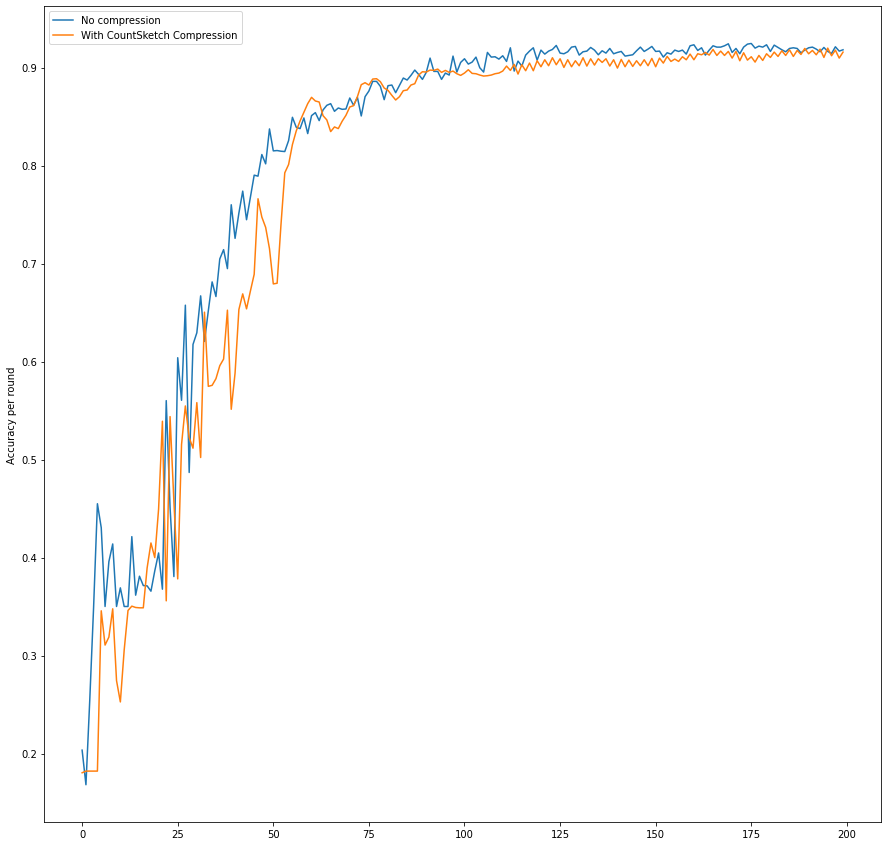

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_7_no_compression)
plt.plot(accuracy_history_poc_10_7)
plt.ylabel('Accuracy per round')
plt.legend(["No compression","With CountSketch Compression"])

plt.show()

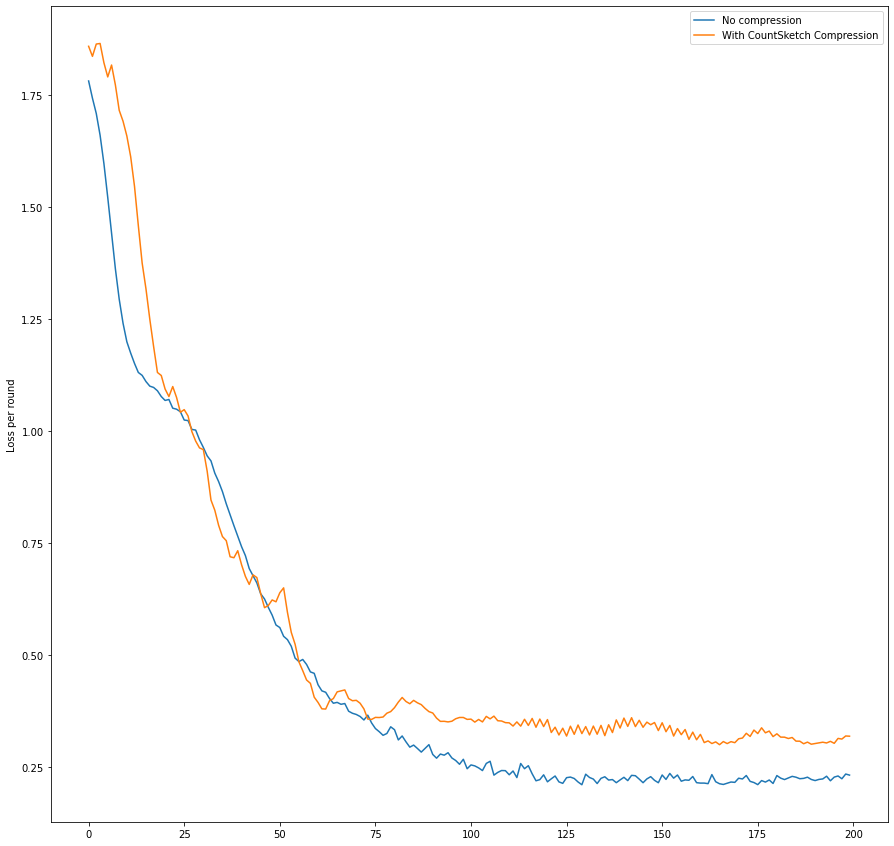

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(loss_history_poc_10_7_no_compression)
plt.plot(loss_history_poc_10_7_)
plt.ylabel('Loss per round')
plt.legend(["No compression","With CountSketch Compression"])

plt.show()

### **All participating clients are training the global model**

**10 clients fully participating**

In [ ]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = 1.0    #percentage of clients selected among the clients considered

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 400

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

s = 0
while s < 10:
  initial_global_model = returnInitialGlobalModel()
  final_global_model, accuracy_history__all_parti_clients_training, num_rounds = runTraining(initial_global_model, accuracy_score_target , clients_dataset)
  num_rounds_list.append(num_rounds)
  
  s+= 1

print("Number of rounds till convergence : ", num_rounds_list)

### **Comparisons**

In [ ]:
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history__all_parti_clients_training)
plt.ylabel('Accuracy per round')
plt.legend(["P-O-C", "All partipating clients in training"])
plt.show()

## **Repeating experiments many times**

In [15]:
numexperiments = 15

### **With compression**

**10 - 7**

In [ ]:
#FL environment parameters
num_clients = len(df_train['subject'].unique())

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 7 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 300

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObjectPerPerson(df_train)


a = 0

accuracy_matrix = []
loss_matrix = []
num_rounds_list = 0

while a < numexperiments:

  initial_global_model = returnInitialGlobalModel()
  final_global_model, accuracy_history_compr, loss_history_compr, num_rounds_compr, clients_considered_history = runTrainingWithCompression(initial_global_model, accuracy_score_target , clients_dataset)

  accuracy_matrix.append(accuracy_history_compr)
  loss_matrix.append(loss_history_compr)
  num_rounds_list = num_rounds_list + num_rounds_compr

  a +=1

num_rounds_avg = num_rounds_list / numexperiments

accuracy_avg_list = []
loss_avg_list = []

a = 0

while a < max_num_rounds:
  b = 0
  accuracyelem = 0
  losselem = 0

  while b < numexperiments:  
    accuracyelem = accuracyelem + accuracy_matrix[b][a]
    losselem = losselem + loss_matrix[b][a]
    b +=1

  accuracy_avg_list.append(accuracyelem / numexperiments)
  loss_avg_list.append(losselem / numexperiments)
    
  a +=1
  
print(accuracy_avg_list)
print(loss_avg_list)
print(num_rounds_list)
print(num_rounds_avg)

Starting
Before training global model accuracy = [1.9911621809005737, 0.15982355177402496]

Creating CSVEC Table
   Columns: 5000
   Rows: 6
   Compression: 0.10830403107603664
